In [1]:
from importlib import reload
import sys
import os
sys.path.insert(0, './..')
sys.path.insert(0, './../scripts')

In [2]:
from importlib import reload

import pickle
import time

import numpy as np
import tensorflow as tf
import logging
from scipy import linalg
from scipy import optimize
from scipy import sparse
from scipy import special

import matplotlib.pyplot as plt

import plot_func as pf

import dev_ori_sel_RF
from dev_ori_sel_RF import connectivity,inputs

2024-04-25 21:53:38.280396: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Define Network Parameters

In [3]:
def fio_rect(x):
#     x[x<0] = 0
#     return x
    return np.fmax(x,0)

In [4]:
N = 96
Nret = N
Nlgn = N

xs,ys = np.meshgrid(np.arange(N)/N,np.arange(N)/N)
dxs = np.abs(xs.flatten()[:,None] - xs.flatten()[None,:])
dxs[dxs > 0.5] = 1 - dxs[dxs > 0.5]
dys = np.abs(ys.flatten()[:,None] - ys.flatten()[None,:])
dys[dys > 0.5] = 1 - dys[dys > 0.5]
ds = np.sqrt(dxs**2 + dys**2)

# Define LGN RFs with Weak Antagonistic Surround

In [8]:
conn_params = {
    'sigma1':  0.037,
    'sigma2':  0.15,
    'ampl1':   1.0,
    'ampl2':   0.4,
    'noise':   0.0,
    'profile': 'Mexican-hat',
    'stevensetal': False
}

reload(connectivity)

conn = connectivity.Connectivity((N,N),(N,N),0)

In [9]:
WRtoT,_ = conn.create_matrix(conn_params,conn_params['profile'])

In [10]:
dists = np.linspace(0,0.71,72)
bin_idxs = np.digitize(ds,np.linspace(0,0.7,71)+0.005)

WRtoT_d = np.zeros(72)

for idx in range(72):
    WRtoT_d[idx] = np.mean(WRtoT[bin_idxs == idx])

Text(0.5, 1.0, 'Sum of Presynaptic Weights')

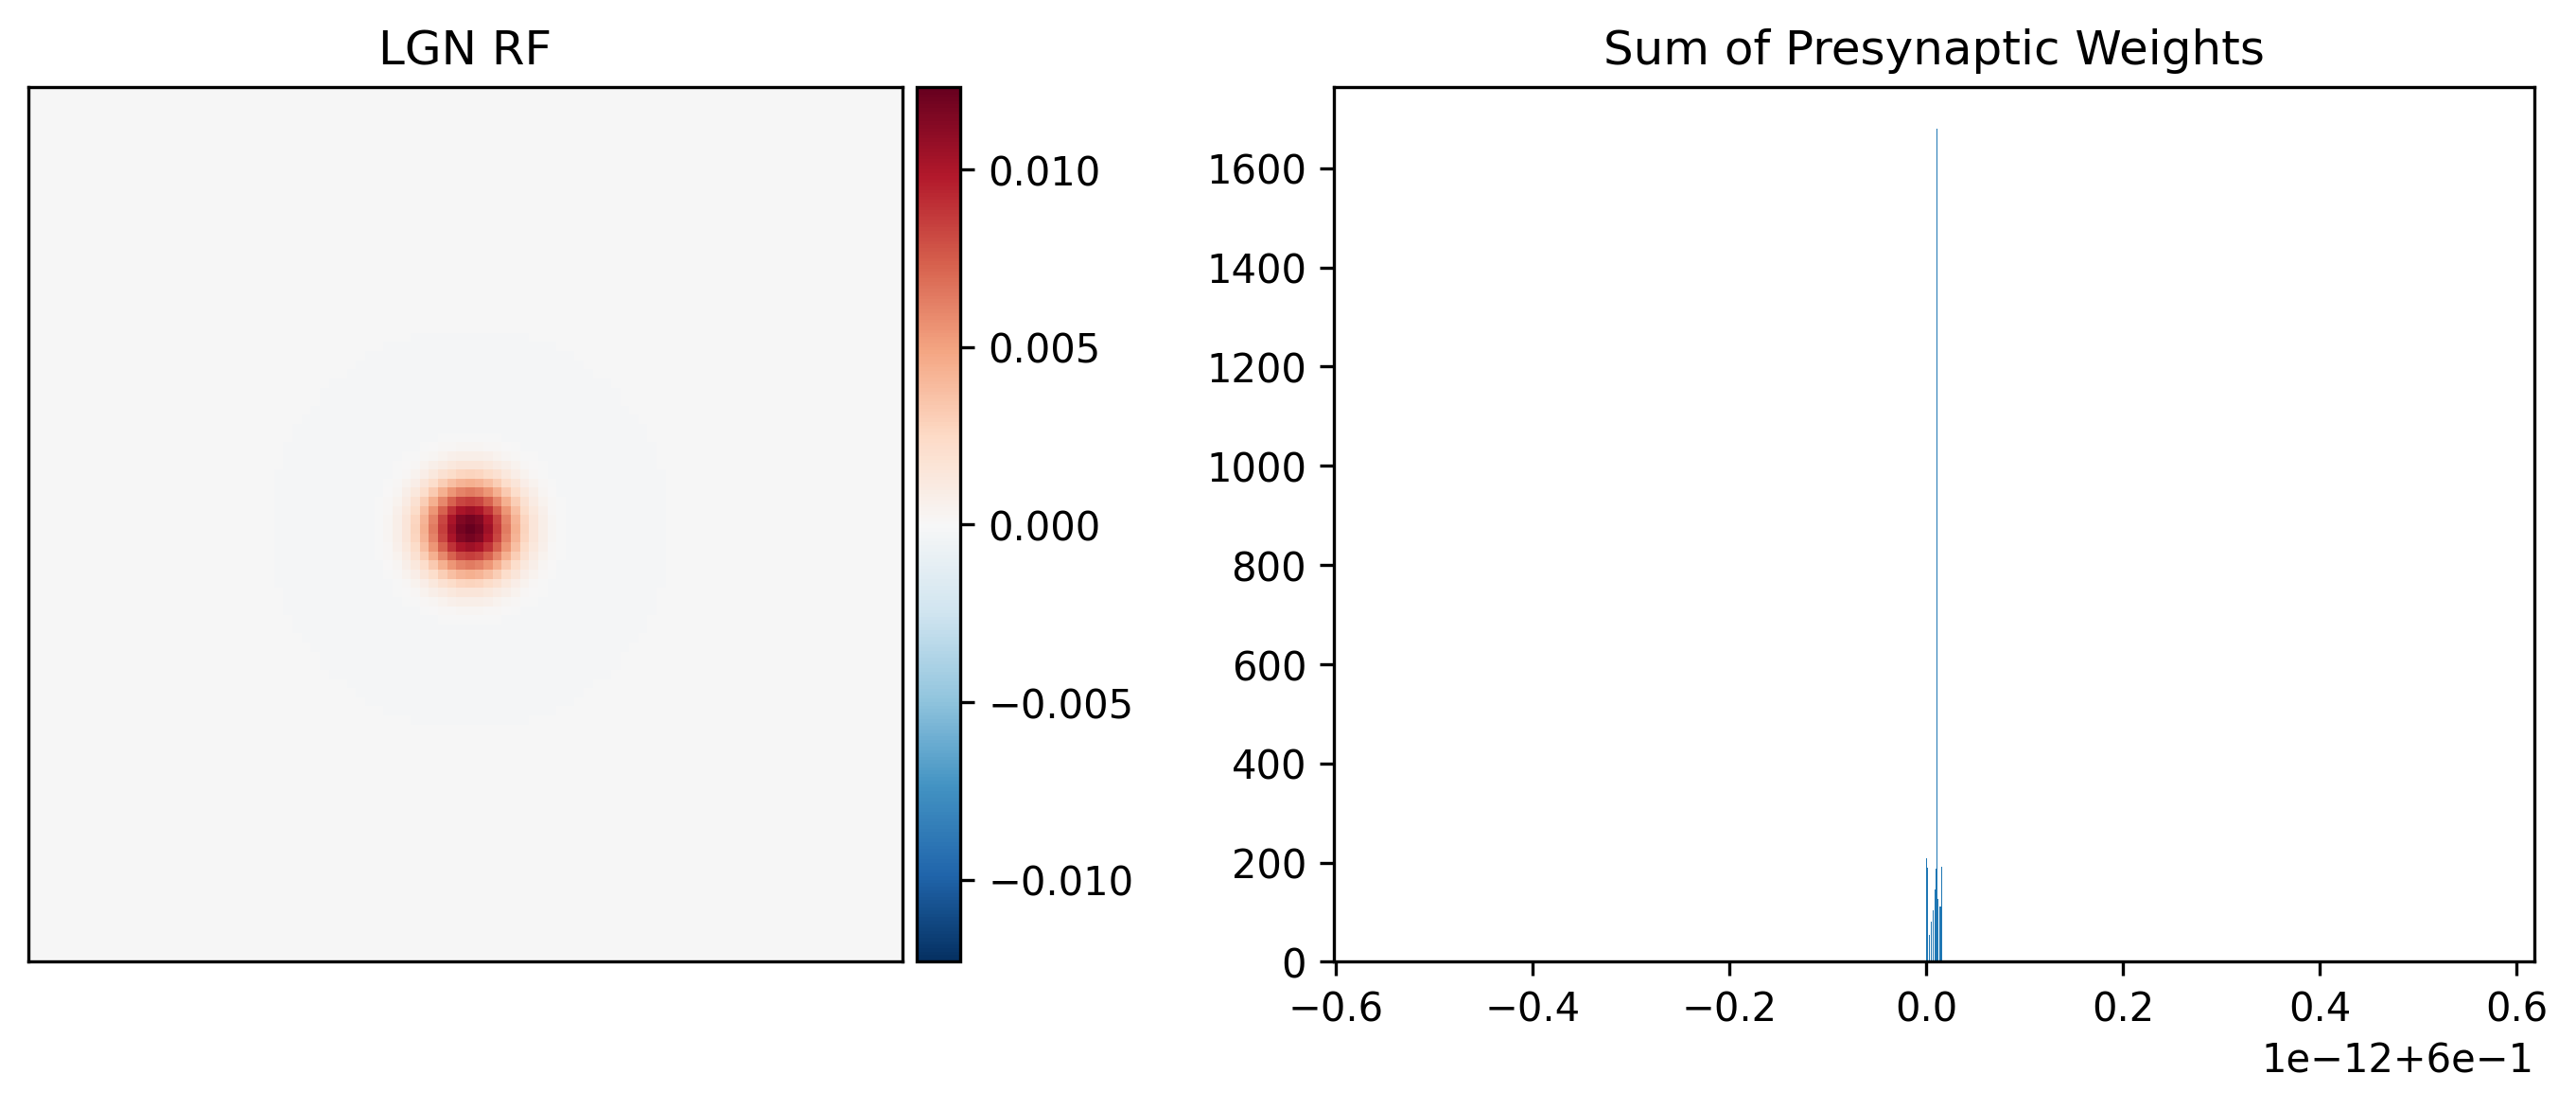

In [8]:
fig,axs = plt.subplots(1,2,figsize=(12,4),dpi=300)
fig.subplots_adjust(hspace=.2, wspace=.2)

pf.imshowbar(fig,axs[0],WRtoT.reshape(N,N,N,N)[N//2,N//2,:,:],
          vmin=-np.max(np.abs(WRtoT)),vmax=np.max(np.abs(WRtoT)))

axs[1].hist(np.sum(WRtoT,1),50)

axs[0].set_title('LGN RF')
axs[1].set_title('Sum of Presynaptic Weights')

# Look at Stevens et al LGN Input

## Create Retinal Activity Patterns

In [9]:
def stevens_gauss(x,y,ori,size=0.088388,aspect_ratio=4.66667,grid_size=1.0,n_grid=Nret):
    pts = np.arange(n_grid)*grid_size/n_grid - grid_size/2
    ysigma = size/2.0
    xsigma = aspect_ratio*ysigma
    
    dx,dy = np.meshgrid(pts,pts)
    
    tmp = np.cos(ori)*dx - np.sin(ori)*dy
    dy = np.sin(ori)*dx + np.cos(ori)*dy
    dx = tmp
    
    dx = dx/xsigma
    dy = dy/ysigma
    
    return np.roll(np.exp(-0.5*(dx**2+dy**2)),(x-n_grid//2,y-n_grid//2),(0,1))

Text(0.5, 1.0, 'Off Layer Activation')

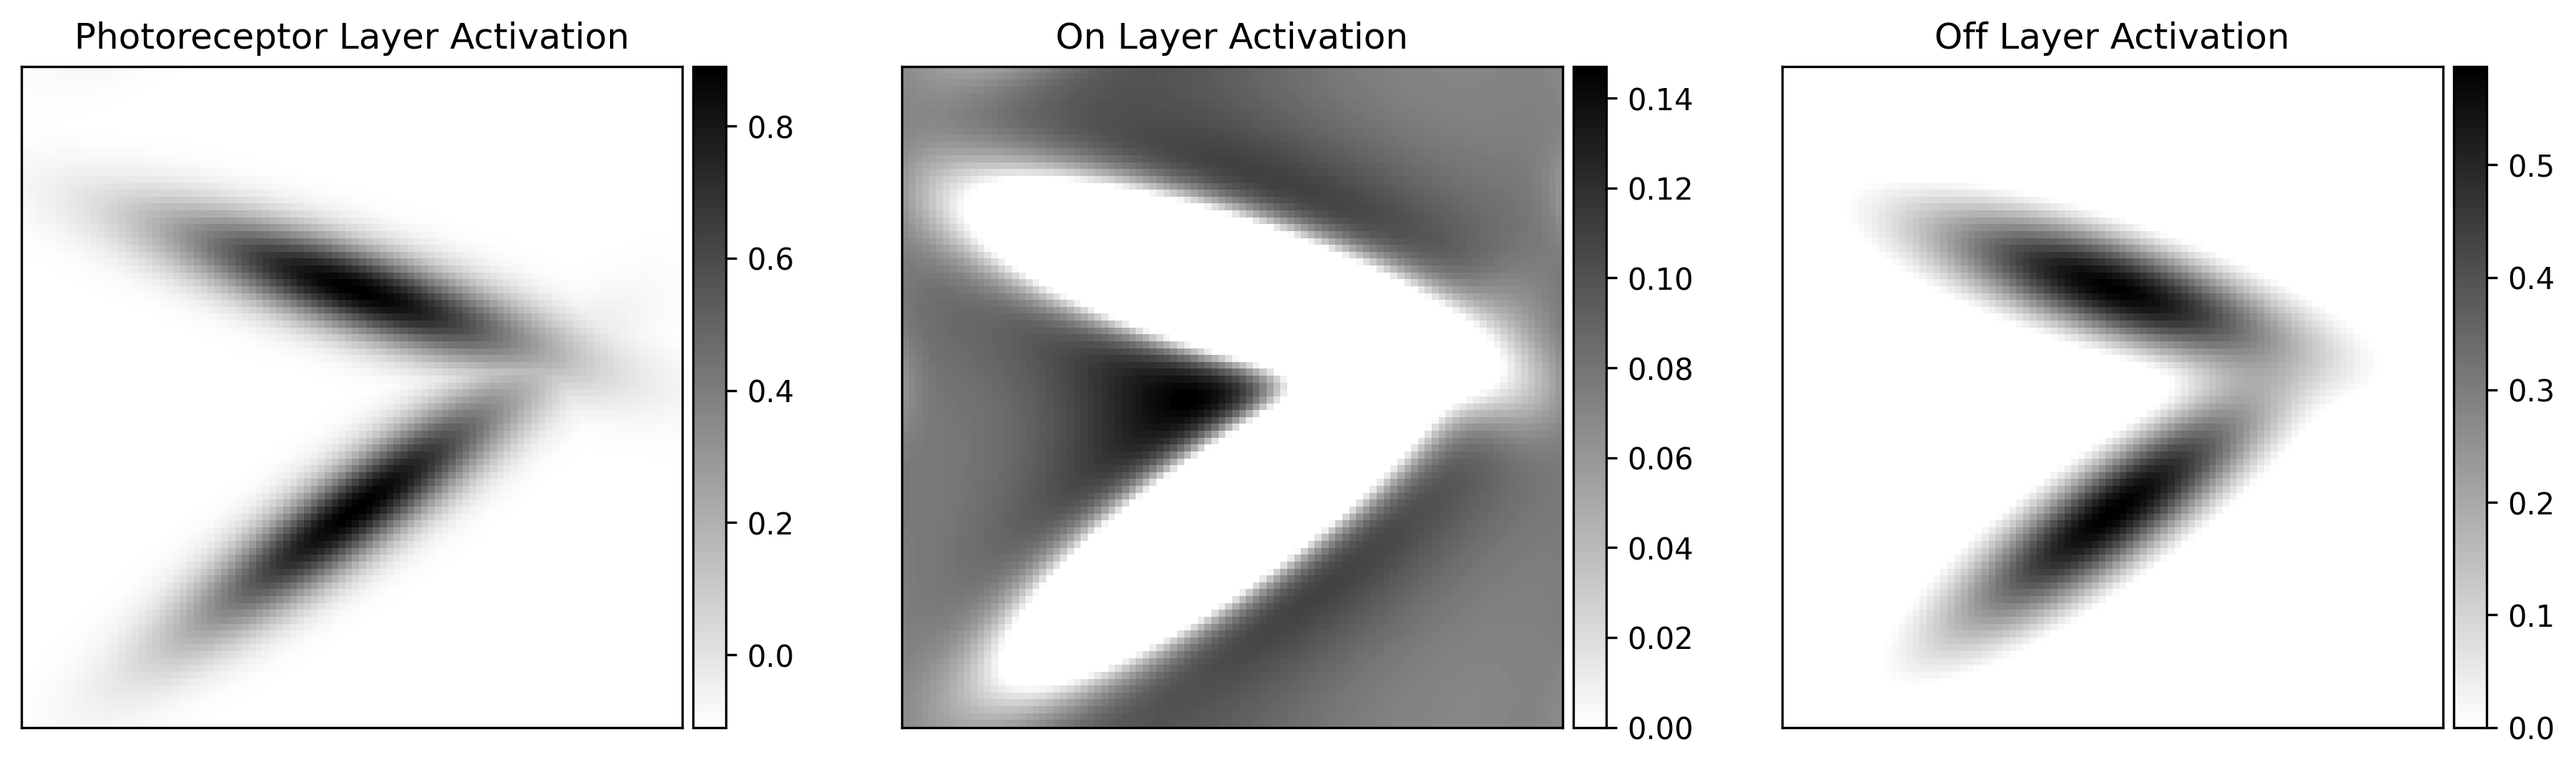

In [39]:
fig,axs = plt.subplots(1,3,figsize=(15,4),dpi=300)

psi = np.fmax(stevens_gauss(Nret//3,Nret//2,np.pi*0.9),stevens_gauss(2*Nret//3,Nret//2,np.pi*0.2))
psi -= np.mean(psi)
Wpatt = np.matmul(WRtoT,psi.flatten()).reshape(Nret,Nret)
pf.imshowbar(fig,axs[0],psi,cmap='binary')
pf.imshowbar(fig,axs[1],fio_rect(-Wpatt),cmap='binary')
pf.imshowbar(fig,axs[2],fio_rect(Wpatt),cmap='binary')

axs[0].set_title('Photoreceptor Layer Activation')
axs[1].set_title('On Layer Activation')
axs[2].set_title('Off Layer Activation')

In [42]:
n_ret_patts = 1000
gaus_psis = 0.25*np.stack([stevens_gauss(np.random.default_rng(0).integers(Nret,size=(2*n_ret_patts))[i],
                                    np.random.default_rng(1).integers(Nret,size=(2*n_ret_patts))[i],
                                    np.pi*np.random.default_rng(2).random(size=(2*n_ret_patts))[i]) for i in
                      range(2*n_ret_patts)]).reshape(
    2,n_ret_patts,Nret**2)
gaus_psis = np.fmax(gaus_psis[0],gaus_psis[1])
gaus_psis -= np.mean(gaus_psis,-1)[:,None]

In [43]:
gaus_Wpsis = np.einsum('ij,kj->ki',WRtoT,gaus_psis)

Text(0.5, 1.0, 'Input to LGN Histogram')

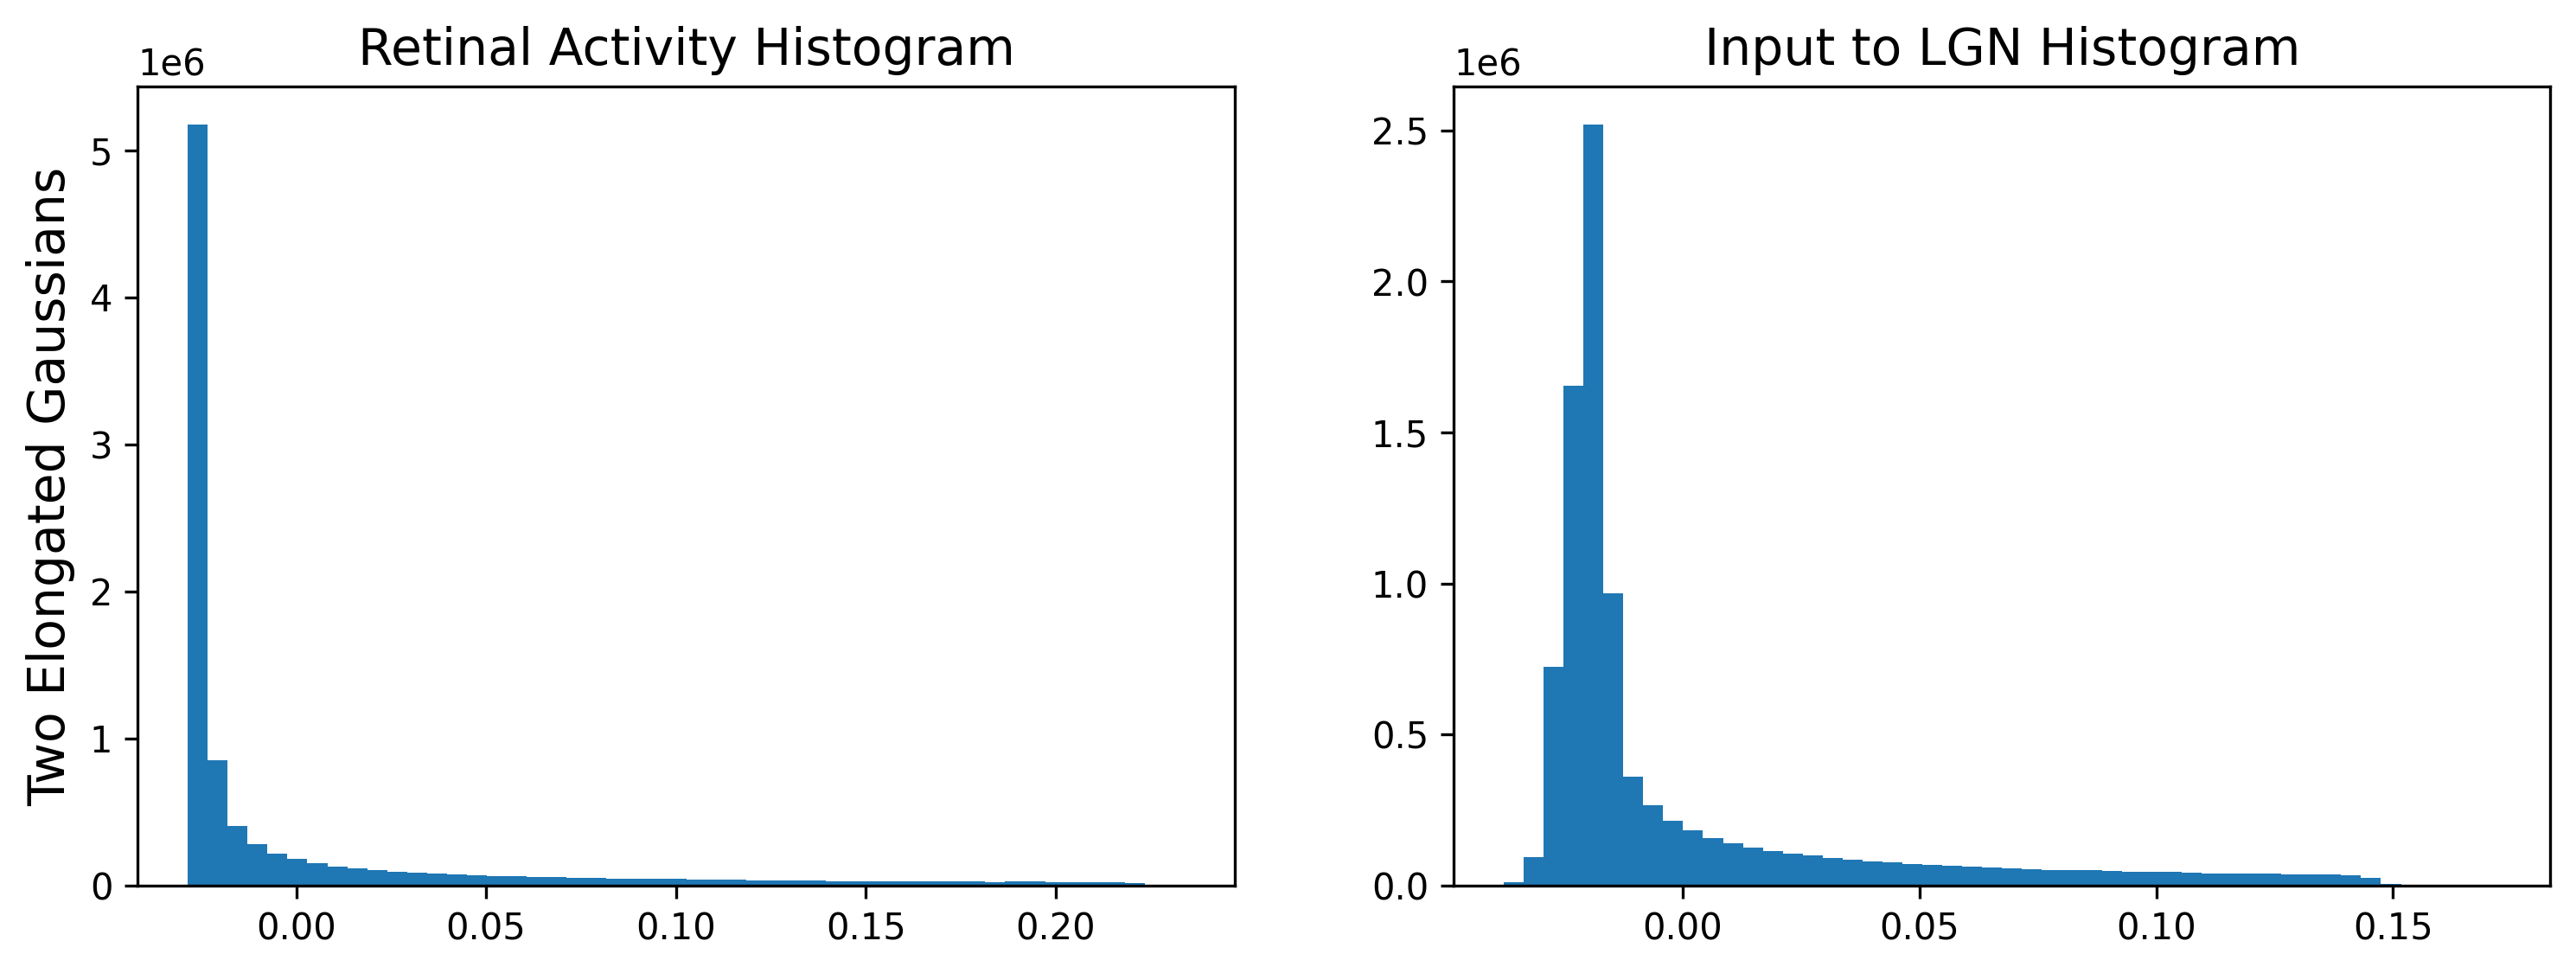

In [44]:
fig,axs = plt.subplots(1,2,figsize=(12,4),dpi=300)
fig.subplots_adjust(hspace=.2, wspace=.2)

axs[0].hist(gaus_psis.flatten(),50)
axs[1].hist(gaus_Wpsis.flatten(),50)

axs[0].set_ylabel('Two Elongated Gaussians',fontsize=14)
axs[0].set_title('Retinal Activity Histogram',fontsize=14)
axs[1].set_title('Input to LGN Histogram',fontsize=14)

In [45]:
gaus_N_act = 14*fio_rect(-gaus_Wpsis)
gaus_F_act = 14*fio_rect(gaus_Wpsis)

Text(0.5, 1.0, 'Off Cell Activity Histogram')

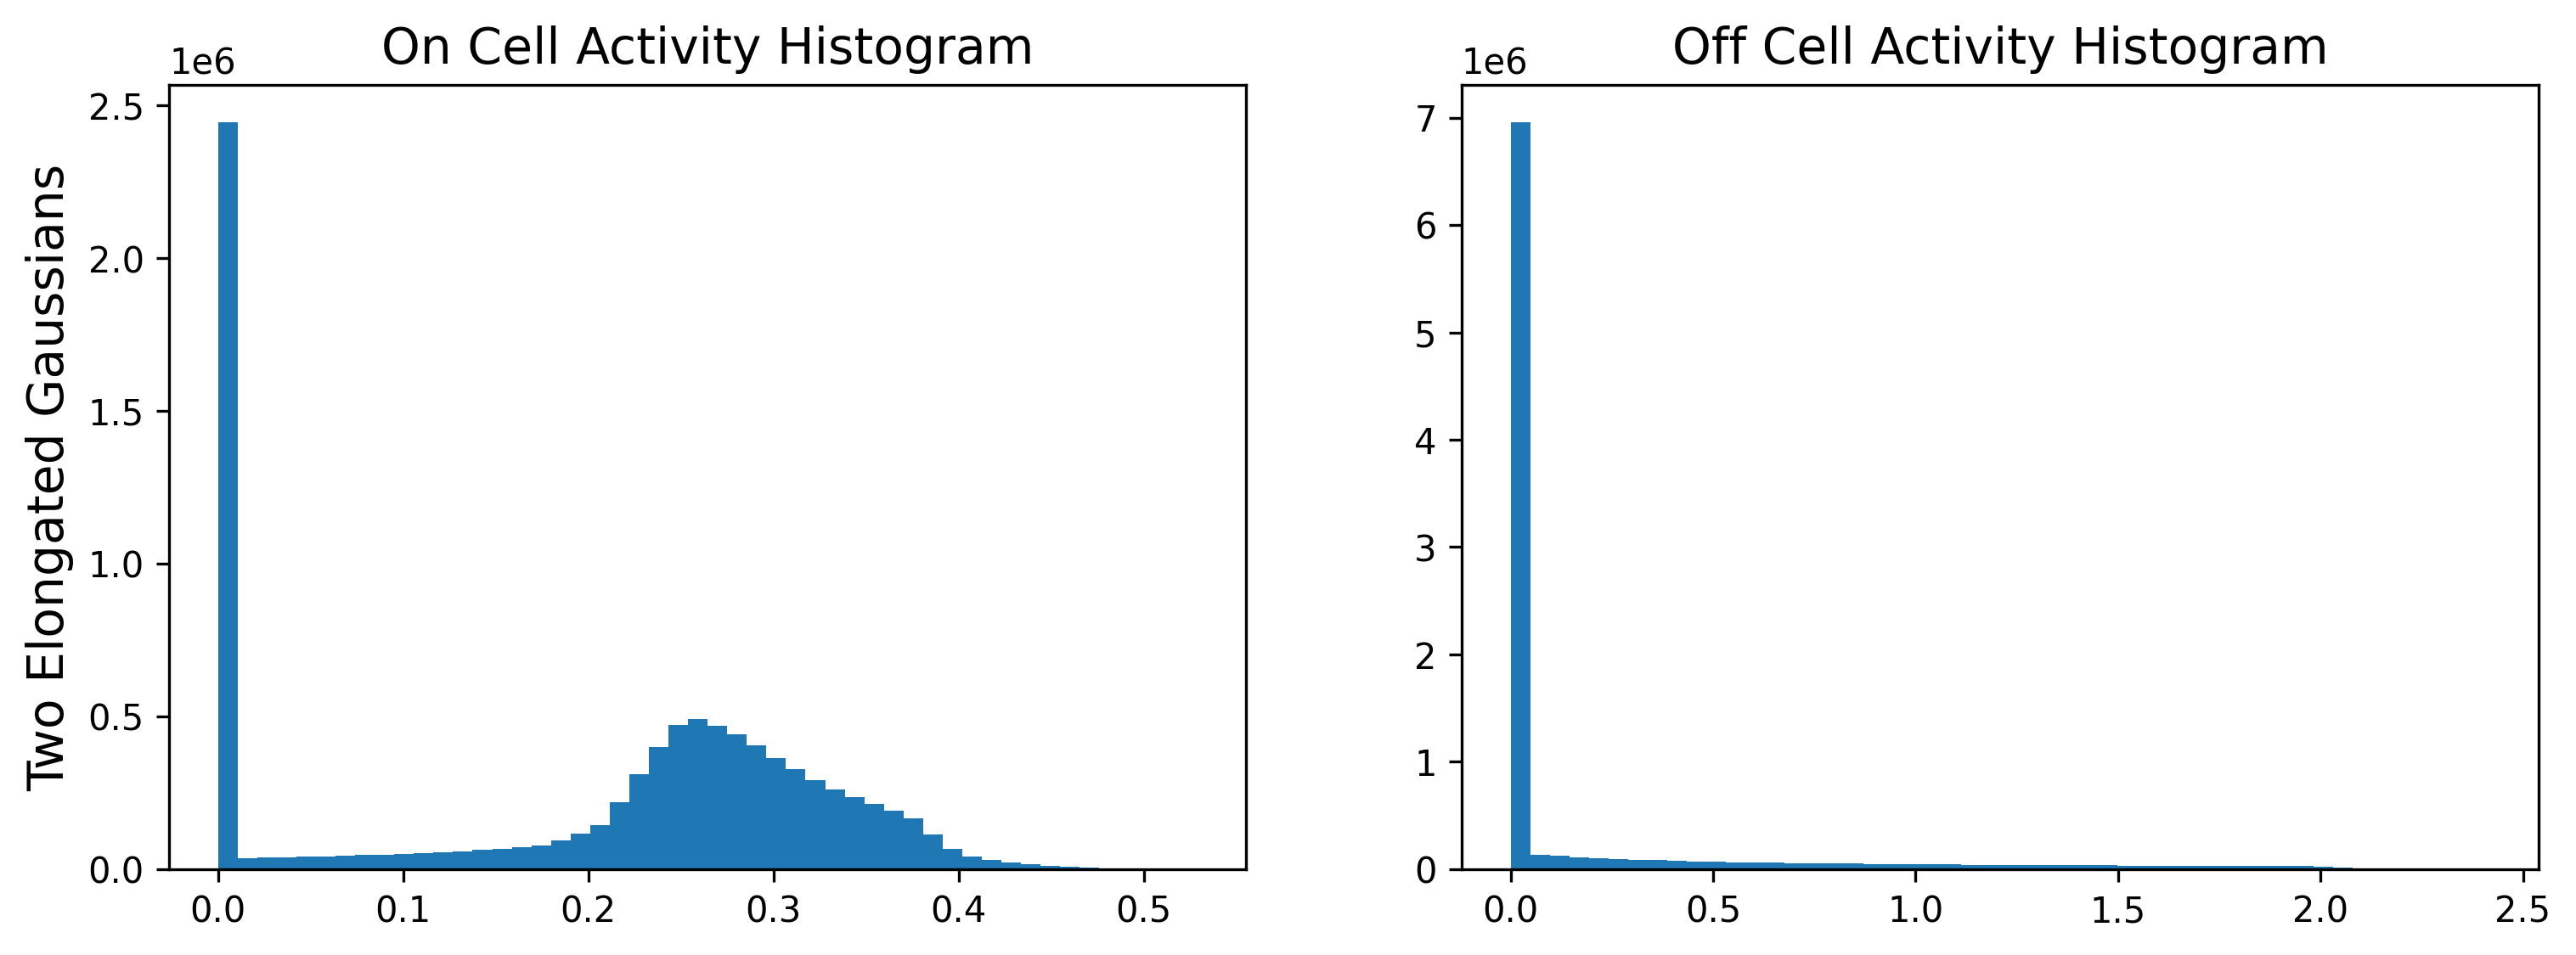

In [46]:
fig,axs = plt.subplots(1,2,figsize=(12,4),dpi=300)
fig.subplots_adjust(hspace=.2, wspace=.2)

axs[0].hist(gaus_N_act.flatten(),50)
axs[1].hist(gaus_F_act.flatten(),50)

axs[0].set_ylabel('Two Elongated Gaussians',fontsize=14)
axs[0].set_title('On Cell Activity Histogram',fontsize=14)
axs[1].set_title('Off Cell Activity Histogram',fontsize=14)

In [47]:
gaus_full_cov = np.cov(gaus_N_act.T,gaus_F_act.T)
gaus_NN_cov = gaus_full_cov[:N**2,:N**2]
gaus_NF_cov = gaus_full_cov[:N**2,N**2:]
gaus_FN_cov = gaus_full_cov[N**2:,:N**2]
gaus_FF_cov = gaus_full_cov[N**2:,N**2:]

In [48]:
dists = np.linspace(0,0.71,72)
bin_idxs_4d = np.digitize(ds,np.linspace(0,0.7,71)+0.005)
bin_idxs_2d = np.digitize(ds[0,:],np.linspace(0,0.7,71)+0.005)

gaus_SN_cov = np.zeros(72)
gaus_SN_cov_err = np.zeros(72)
gaus_SF_cov = np.zeros(72)
gaus_SF_cov_err = np.zeros(72)
gaus_D_cov = np.zeros(72)
gaus_D_cov_err = np.zeros(72)

for idx in range(72):
    gaus_SN_cov[idx] = np.mean(gaus_NN_cov[bin_idxs_4d == idx])
    gaus_SN_cov_err[idx] = np.sqrt(np.var(gaus_NN_cov[bin_idxs_4d == idx]))
    gaus_SF_cov[idx] = np.mean(gaus_FF_cov[bin_idxs_4d == idx])
    gaus_SF_cov_err[idx] = np.sqrt(np.var(gaus_FF_cov[bin_idxs_4d == idx]))
    gaus_D_cov[idx] = 0.5*(np.mean(gaus_NF_cov[bin_idxs_4d == idx]) +\
                           np.mean(gaus_NF_cov[bin_idxs_4d == idx]))
    gaus_D_cov_err[idx] = np.sqrt(np.var(gaus_NF_cov[bin_idxs_4d == idx]) +\
                                  np.var(gaus_NF_cov[bin_idxs_4d == idx]))

Text(0.5, 1.0, 'Stevens et al LGN Activity Covariance with Gaussian Bars Retinal Activity')

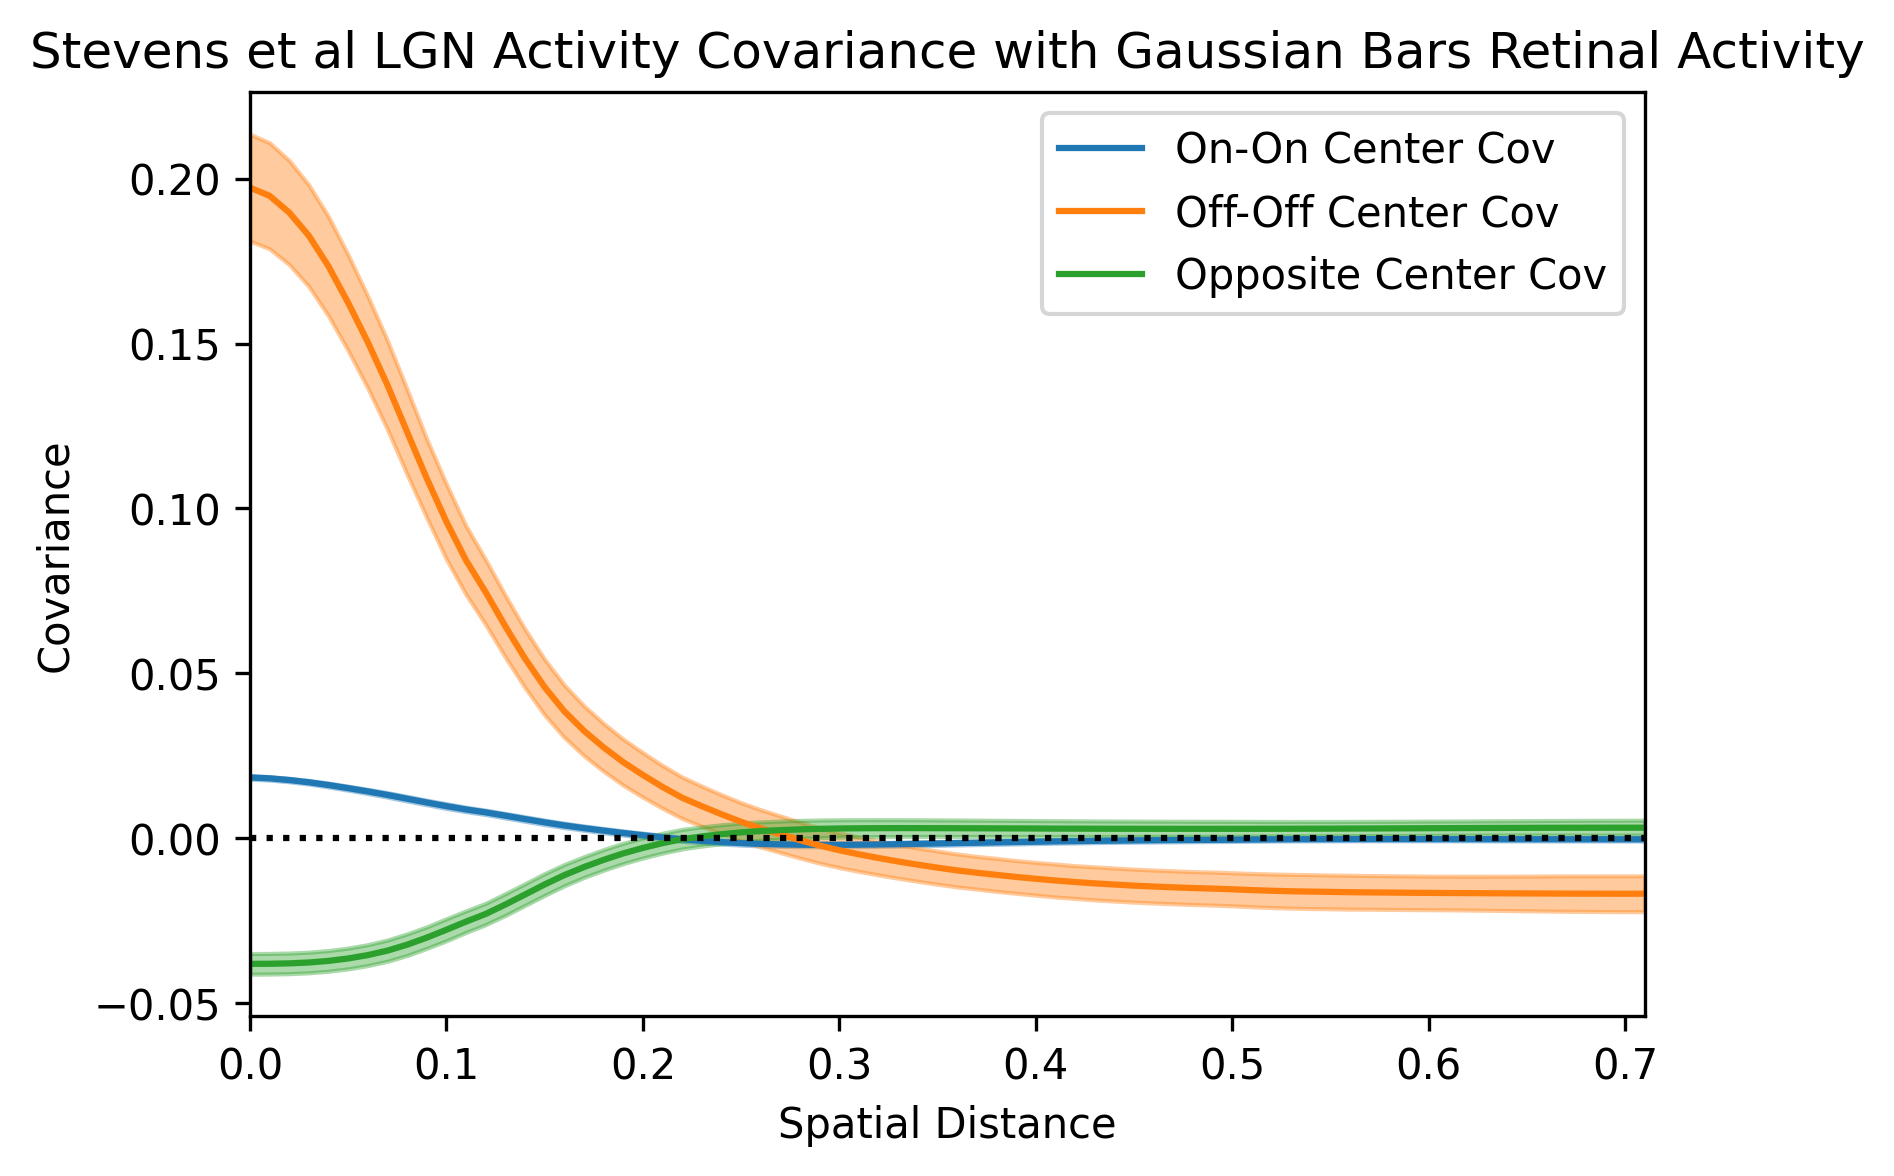

In [49]:
fig,axs = plt.subplots(1,1,figsize=(6,4),dpi=300,sharex=True,sharey=True)
fig.subplots_adjust(hspace=.2, wspace=.2)

axs.plot(dists,gaus_SN_cov,c='C0',label='On-On Center Cov')
axs.fill_between(dists,gaus_SN_cov-gaus_SN_cov_err,gaus_SN_cov+gaus_SN_cov_err,color='C0',alpha=0.4)
axs.plot(dists,gaus_SF_cov,c='C1',label='Off-Off Center Cov')
axs.fill_between(dists,gaus_SF_cov-gaus_SF_cov_err,gaus_SF_cov+gaus_SF_cov_err,color='C1',alpha=0.4)
axs.plot(dists,gaus_D_cov,c='C2',label='Opposite Center Cov')
axs.fill_between(dists,gaus_D_cov-gaus_D_cov_err,gaus_D_cov+gaus_D_cov_err,color='C2',alpha=0.4)

# for i in range(2):
#     axs[i].plot(dists,5*WRtoT_d,'k--',label='Receptive Field')
axs.axhline(0,c='k',ls=':')

axs.legend()

axs.set_xlim(dists[0],dists[-1])

axs.set_xlabel('Spatial Distance')
axs.set_ylabel('Covariance')
    
axs.set_title('Stevens et al LGN Activity Covariance with Gaussian Bars Retinal Activity')

# Look at Correlations with Bandpass Filtered Noise

## Create Retinal Activity Patterns

In [22]:
x,y = np.meshgrid(np.linspace(-N//2,N//2-1,N),np.linspace(-N//2,N//2-1,N))
sig1 = 1.8*6/5
sig2 = 3.6*6/5
kern1 = 1./(np.sqrt(np.pi*2)*sig1)**2*np.exp((-x**2-y**2)/2./sig1**2)
kern2 = 1./(np.sqrt(np.pi*2)*sig2)**2*np.exp((-x**2-y**2)/2./sig2**2)
diff_gauss = kern1-kern2

ring_image = np.fft.fft2(np.fft.fftshift(diff_gauss))

def bandpass_pattern(seed=0):
    rng = np.random.default_rng(seed)
    random_matrix = np.fft.fft2(rng.normal(size=(N,N)))
    return np.real(np.fft.ifft2(ring_image*random_matrix))

Text(0.5, 1.0, 'Off Layer Activation')

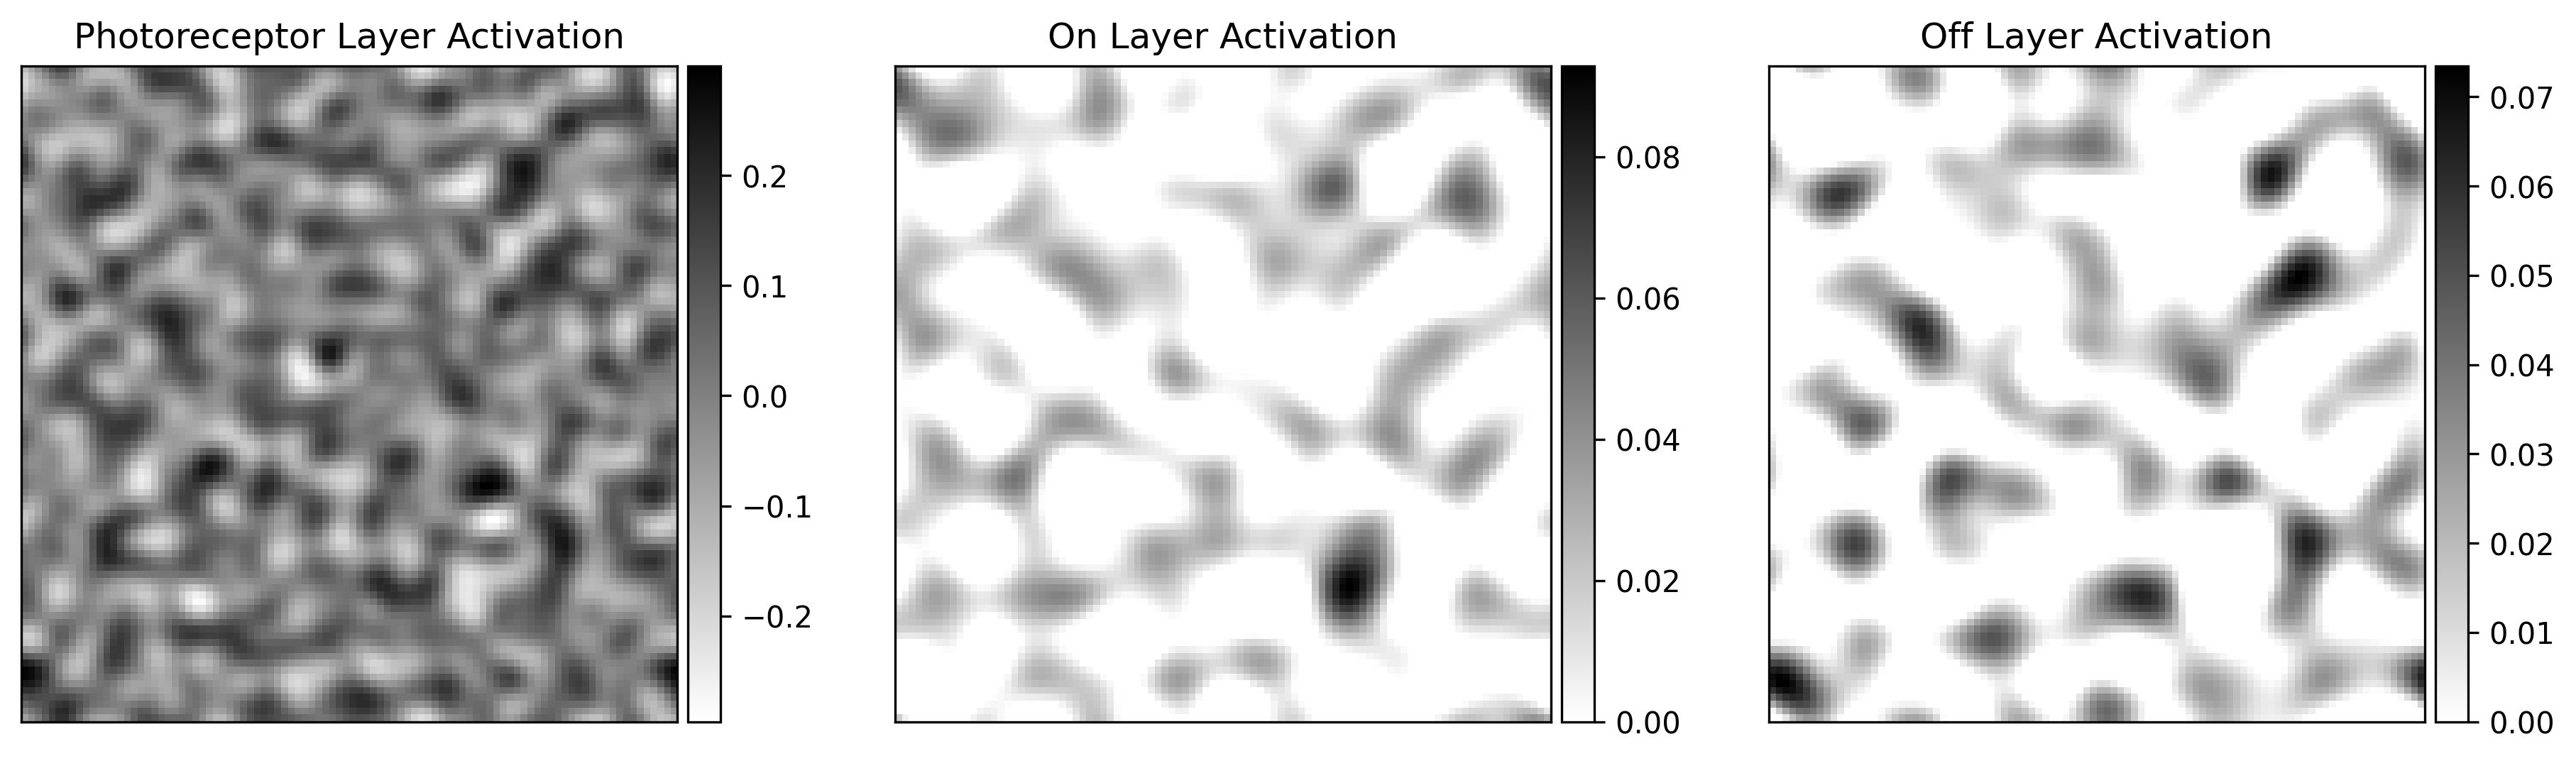

In [23]:
fig,axs = plt.subplots(1,3,figsize=(15,4),dpi=300)

psi = bandpass_pattern()
psi -= np.mean(psi)
Wpatt = np.matmul(WRtoT,psi.flatten()).reshape(Nret,Nret)
pf.imshowbar(fig,axs[0],psi,cmap='binary')
pf.imshowbar(fig,axs[1],fio_rect(-Wpatt),cmap='binary')
pf.imshowbar(fig,axs[2],fio_rect(Wpatt),cmap='binary')

axs[0].set_title('Photoreceptor Layer Activation')
axs[1].set_title('On Layer Activation')
axs[2].set_title('Off Layer Activation')

In [13]:
n_ret_patts = 1000
band_psis = 0.25*np.stack([bandpass_pattern(i) for i in
                      range(n_ret_patts)]).reshape(
    n_ret_patts,Nret**2)
band_psis -= np.mean(band_psis,-1)[:,None]

In [14]:
band_Wpsis = np.einsum('ij,kj->ki',WRtoT,band_psis)

Text(0.5, 1.0, 'Input to LGN Histogram')

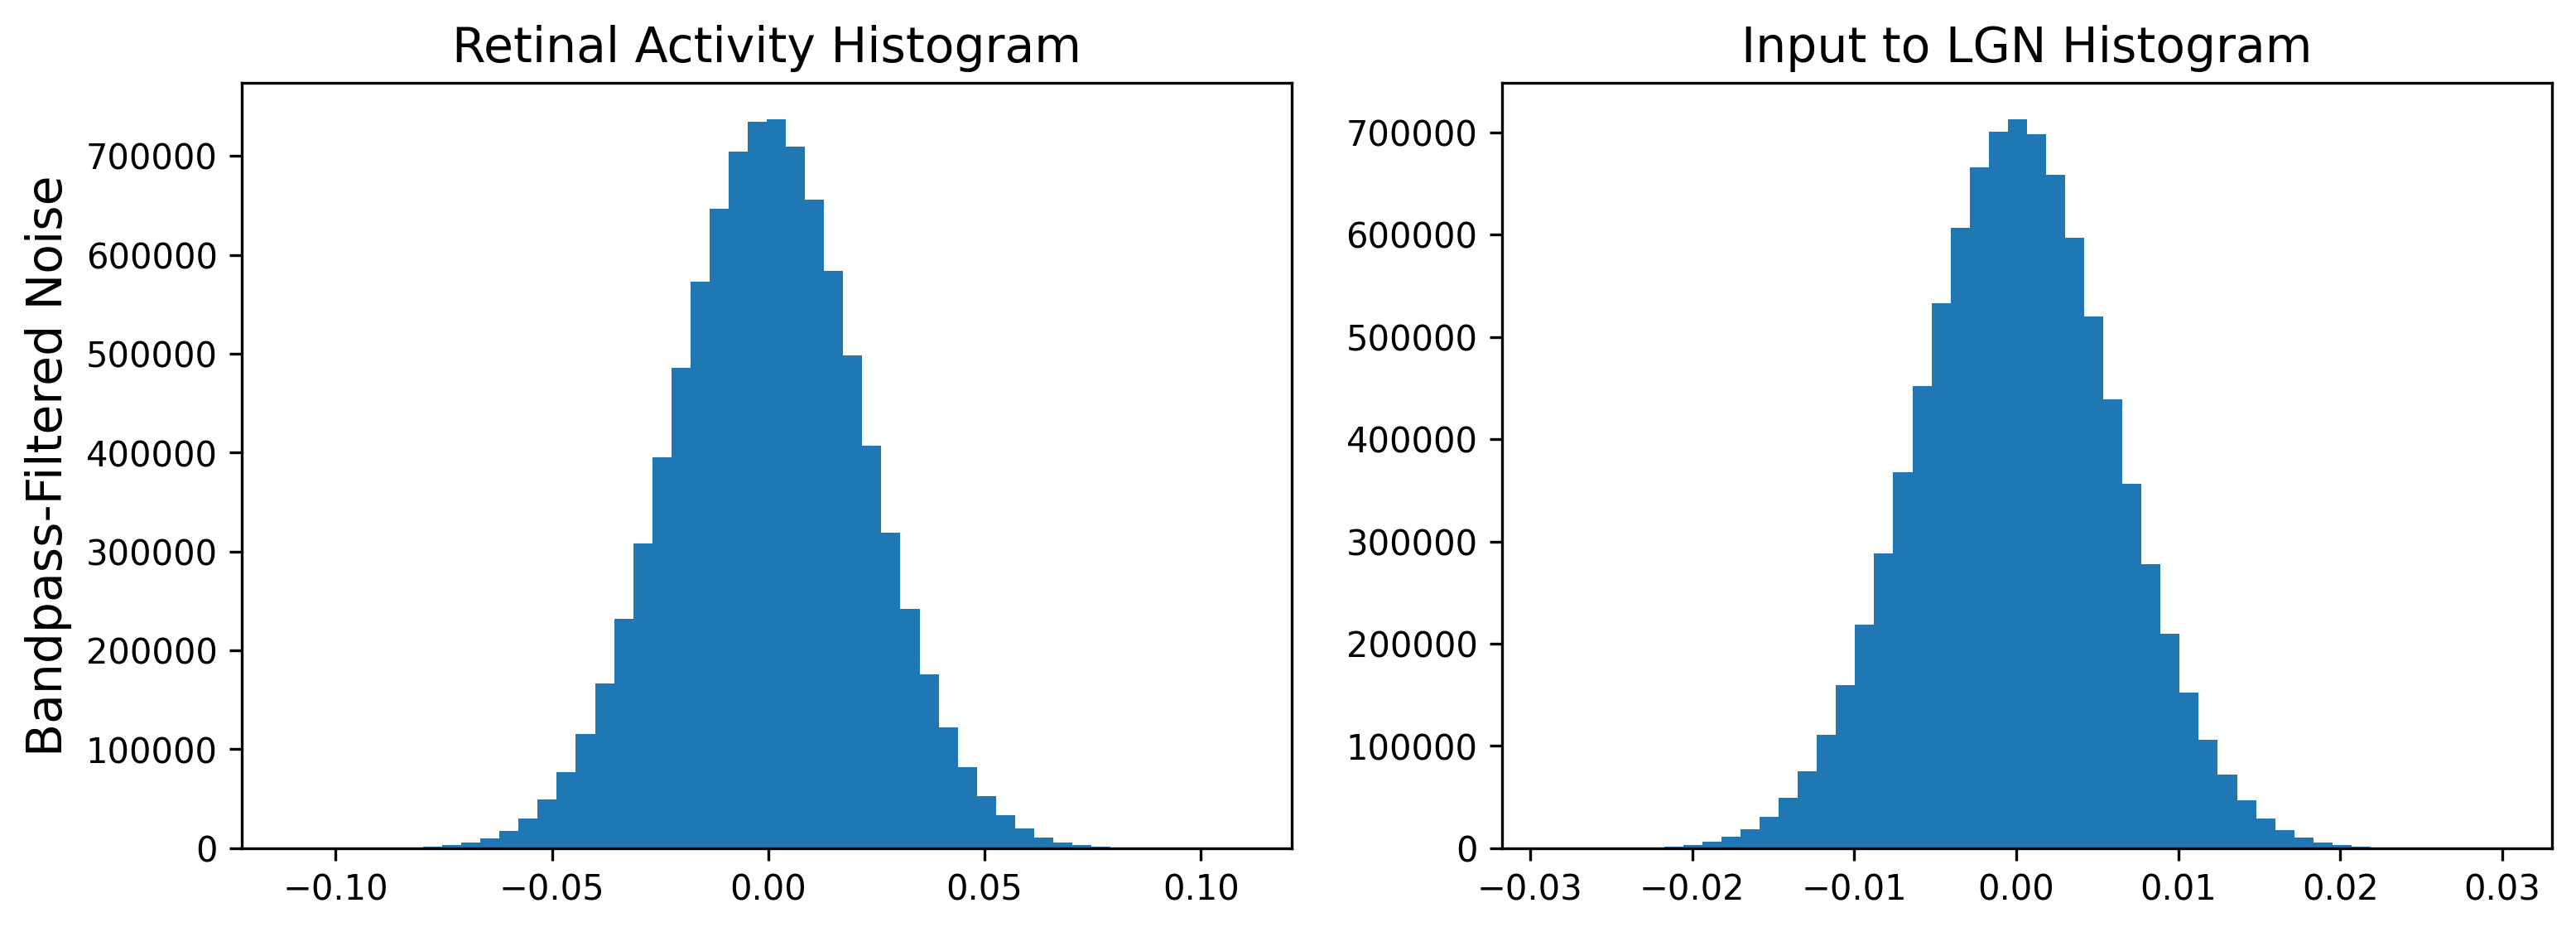

In [15]:
fig,axs = plt.subplots(1,2,figsize=(12,4),dpi=300)
fig.subplots_adjust(hspace=.2, wspace=.2)

axs[0].hist(band_psis.flatten(),50)
axs[1].hist(band_Wpsis.flatten(),50)

axs[0].set_ylabel('Bandpass-Filtered Noise',fontsize=14)
axs[0].set_title('Retinal Activity Histogram',fontsize=14)
axs[1].set_title('Input to LGN Histogram',fontsize=14)

In [16]:
band_N_act = 14*fio_rect(-band_Wpsis)
band_F_act = 14*fio_rect(band_Wpsis)

In [17]:
band_full_cov = np.cov(band_N_act.T,band_F_act.T)
band_NN_cov = band_full_cov[:N**2,:N**2]
band_NF_cov = band_full_cov[:N**2,N**2:]
band_FN_cov = band_full_cov[N**2:,:N**2]
band_FF_cov = band_full_cov[N**2:,N**2:]

In [18]:
dists = np.linspace(0,0.71,72)
bin_idxs_4d = np.digitize(ds,np.linspace(0,0.7,71)+0.005)
bin_idxs_2d = np.digitize(ds[0,:],np.linspace(0,0.7,71)+0.005)

band_SN_cov = np.zeros(72)
band_SN_cov_err = np.zeros(72)
band_SF_cov = np.zeros(72)
band_SF_cov_err = np.zeros(72)
band_D_cov = np.zeros(72)
band_D_cov_err = np.zeros(72)

for idx in range(72):
    band_SN_cov[idx] = np.mean(band_NN_cov[bin_idxs_4d == idx])
    band_SN_cov_err[idx] = np.sqrt(np.var(band_NN_cov[bin_idxs_4d == idx]))
    band_SF_cov[idx] = np.mean(band_FF_cov[bin_idxs_4d == idx])
    band_SF_cov_err[idx] = np.sqrt(np.var(band_FF_cov[bin_idxs_4d == idx]))
    band_D_cov[idx] = 0.5*(np.mean(band_NF_cov[bin_idxs_4d == idx]) +\
                           np.mean(band_NF_cov[bin_idxs_4d == idx]))
    band_D_cov_err[idx] = np.sqrt(np.var(band_NF_cov[bin_idxs_4d == idx]) +\
                                  np.var(band_NF_cov[bin_idxs_4d == idx]))

Text(0.5, 1.0, 'Bandpass LGN Activity Covariance with Gaussian Bars Retinal Activity')

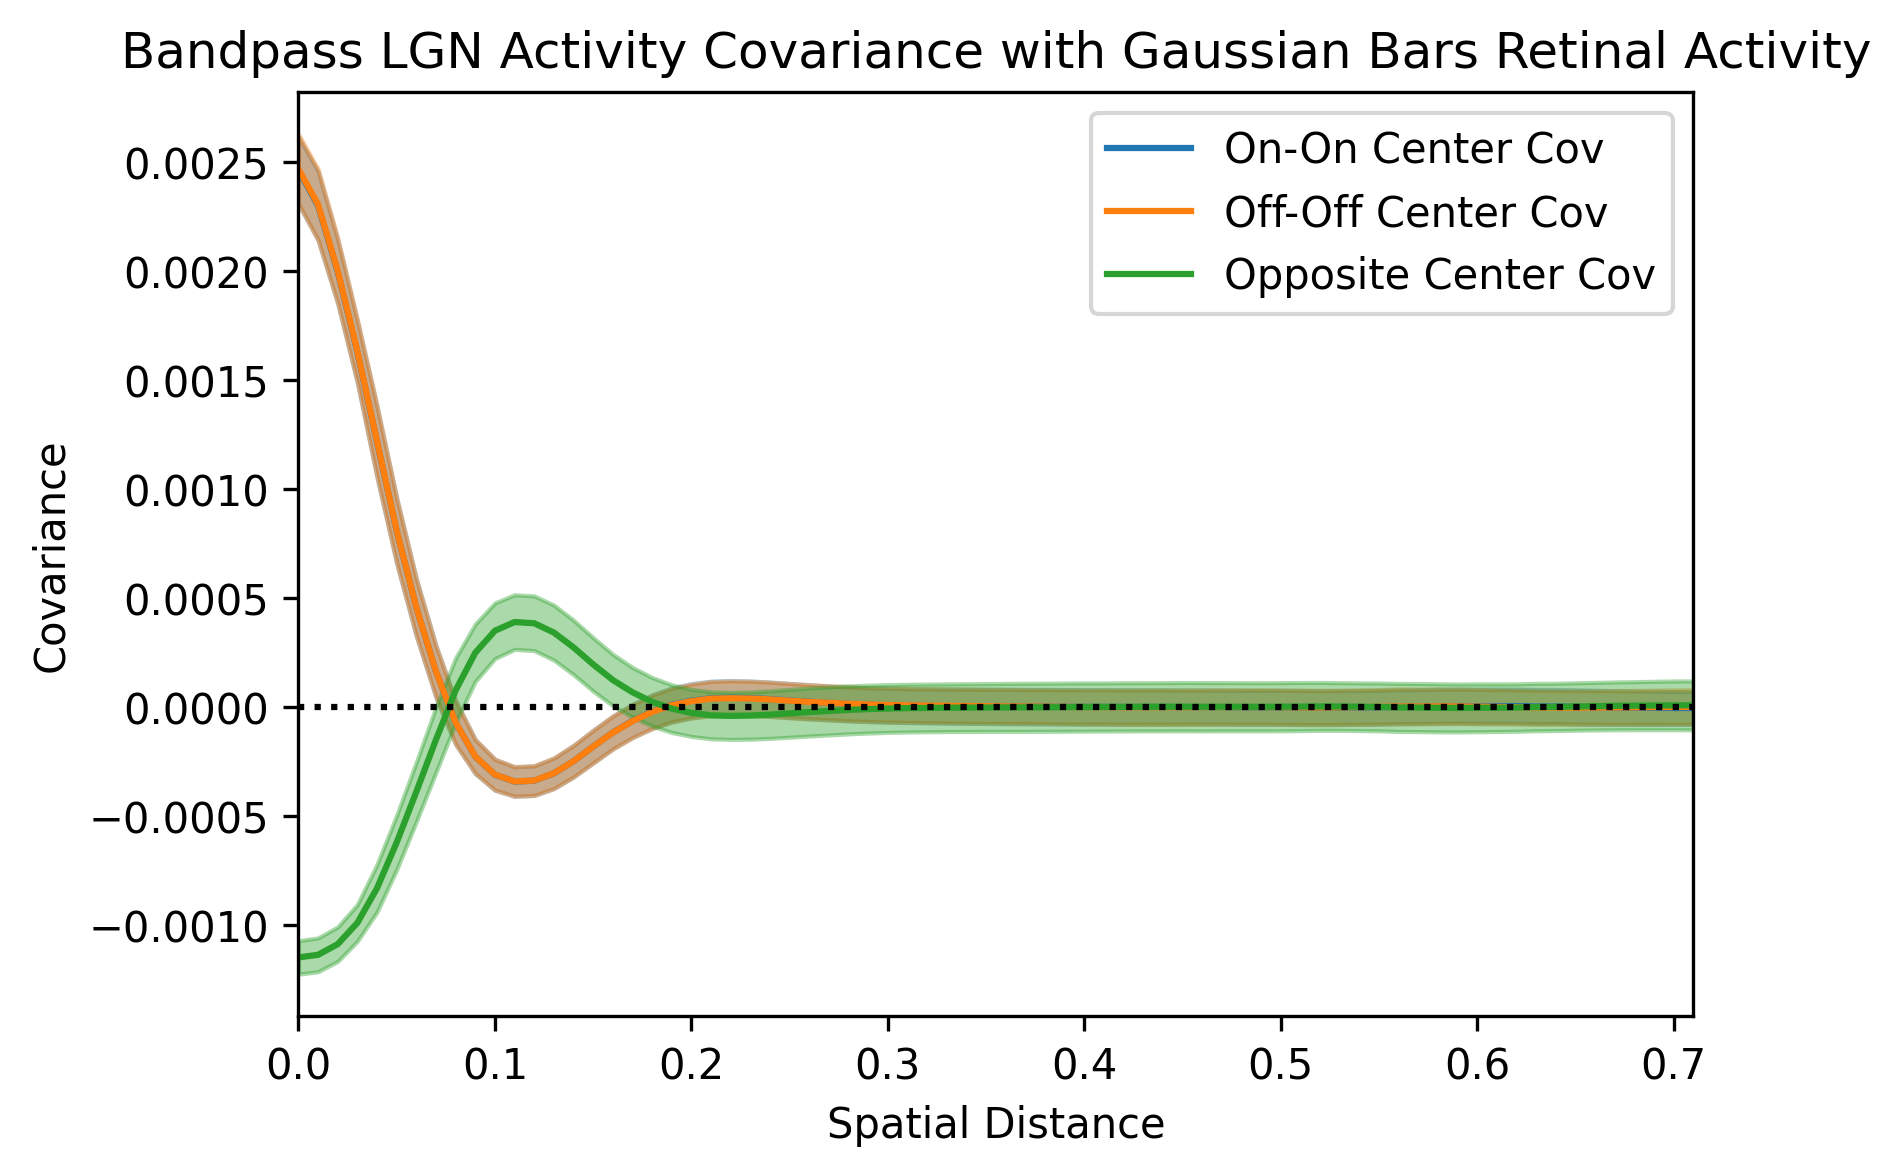

In [19]:
fig,axs = plt.subplots(1,1,figsize=(6,4),dpi=300,sharex=True,sharey=True)
fig.subplots_adjust(hspace=.2, wspace=.2)

axs.plot(dists,band_SN_cov,c='C0',label='On-On Center Cov')
axs.fill_between(dists,band_SN_cov-band_SN_cov_err,band_SN_cov+band_SN_cov_err,color='C0',alpha=0.4)
axs.plot(dists,band_SF_cov,c='C1',label='Off-Off Center Cov')
axs.fill_between(dists,band_SF_cov-band_SF_cov_err,band_SF_cov+band_SF_cov_err,color='C1',alpha=0.4)
axs.plot(dists,band_D_cov,c='C2',label='Opposite Center Cov')
axs.fill_between(dists,band_D_cov-band_D_cov_err,band_D_cov+band_D_cov_err,color='C2',alpha=0.4)

# for i in range(2):
#     axs[i].plot(dists,5*WRtoT_d,'k--',label='Receptive Field')
axs.axhline(0,c='k',ls=':')

axs.legend()

axs.set_xlim(dists[0],dists[-1])

axs.set_xlabel('Spatial Distance')
axs.set_ylabel('Covariance')
    
axs.set_title('LGN Activity Covariance with Bandpass Retinal Activity')

# Look at Correlations with Low-pass Filtered

In [24]:
x,y = np.meshgrid(np.linspace(-N//2,N//2-1,N),np.linspace(-N//2,N//2-1,N))
sig1 = 1.8*6/5
sig2 = 3.6*6/5
kern1 = 1./(np.sqrt(np.pi*2)*sig1)**2*np.exp((-x**2-y**2)/2./sig1**2)
kern2 = 1./(np.sqrt(np.pi*2)*sig2)**2*np.exp((-x**2-y**2)/2./sig2**2)
diff_gauss = kern1-kern2

bump_image = np.fft.fft2(np.fft.fftshift(kern1))

def lowpass_pattern(seed=0):
    rng = np.random.default_rng(seed)
    random_matrix = np.fft.fft2(rng.normal(size=(N,N)))
    return np.real(np.fft.ifft2(bump_image*random_matrix))

Text(0.5, 1.0, 'Off Layer Activation')

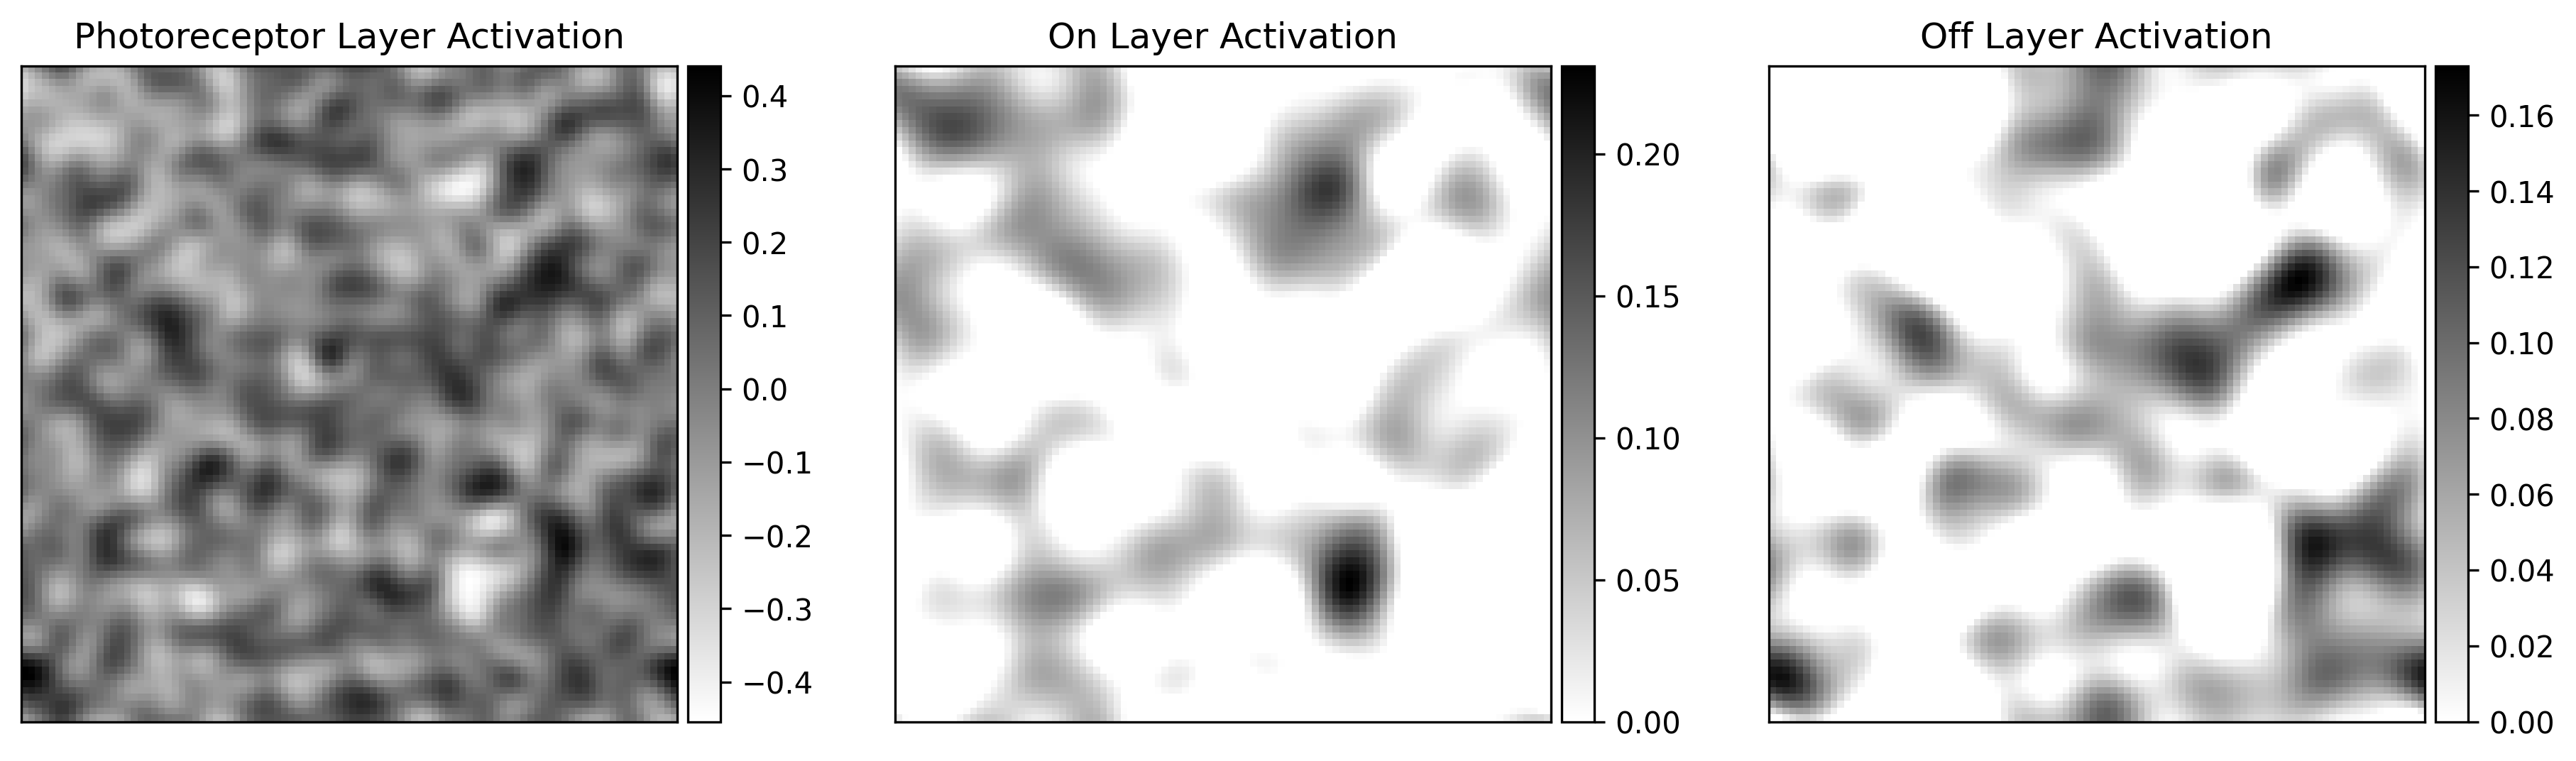

In [26]:
fig,axs = plt.subplots(1,3,figsize=(15,4),dpi=300)

psi = lowpass_pattern()
psi -= np.mean(psi)
Wpatt = np.matmul(WRtoT,psi.flatten()).reshape(Nret,Nret)
pf.imshowbar(fig,axs[0],psi,cmap='binary')
pf.imshowbar(fig,axs[1],fio_rect(-Wpatt),cmap='binary')
pf.imshowbar(fig,axs[2],fio_rect(Wpatt),cmap='binary')

axs[0].set_title('Photoreceptor Layer Activation')
axs[1].set_title('On Layer Activation')
axs[2].set_title('Off Layer Activation')

In [27]:
n_ret_patts = 1000
low_psis = 0.25*np.stack([lowpass_pattern(i) for i in
                      range(n_ret_patts)]).reshape(
    n_ret_patts,Nret**2)
low_psis -= np.mean(low_psis,-1)[:,None]

In [28]:
low_Wpsis = np.einsum('ij,kj->ki',WRtoT,low_psis)

In [29]:
low_N_act = 14*fio_rect(-low_Wpsis)
low_F_act = 14*fio_rect(low_Wpsis)

In [30]:
low_full_cov = np.cov(low_N_act.T,low_F_act.T)
low_NN_cov = low_full_cov[:N**2,:N**2]
low_NF_cov = low_full_cov[:N**2,N**2:]
low_FN_cov = low_full_cov[N**2:,:N**2]
low_FF_cov = low_full_cov[N**2:,N**2:]

In [31]:
dists = np.linspace(0,0.71,72)
bin_idxs_4d = np.digitize(ds,np.linspace(0,0.7,71)+0.005)
bin_idxs_2d = np.digitize(ds[0,:],np.linspace(0,0.7,71)+0.005)

low_SN_cov = np.zeros(72)
low_SN_cov_err = np.zeros(72)
low_SF_cov = np.zeros(72)
low_SF_cov_err = np.zeros(72)
low_D_cov = np.zeros(72)
low_D_cov_err = np.zeros(72)

for idx in range(72):
    low_SN_cov[idx] = np.mean(low_NN_cov[bin_idxs_4d == idx])
    low_SN_cov_err[idx] = np.sqrt(np.var(low_NN_cov[bin_idxs_4d == idx]))
    low_SF_cov[idx] = np.mean(low_FF_cov[bin_idxs_4d == idx])
    low_SF_cov_err[idx] = np.sqrt(np.var(low_FF_cov[bin_idxs_4d == idx]))
    low_D_cov[idx] = 0.5*(np.mean(low_NF_cov[bin_idxs_4d == idx]) +\
                           np.mean(low_NF_cov[bin_idxs_4d == idx]))
    low_D_cov_err[idx] = np.sqrt(np.var(low_NF_cov[bin_idxs_4d == idx]) +\
                                  np.var(low_NF_cov[bin_idxs_4d == idx]))

Text(0.5, 1.0, 'LGN Activity Covariance with Lowpass Retinal Activity')

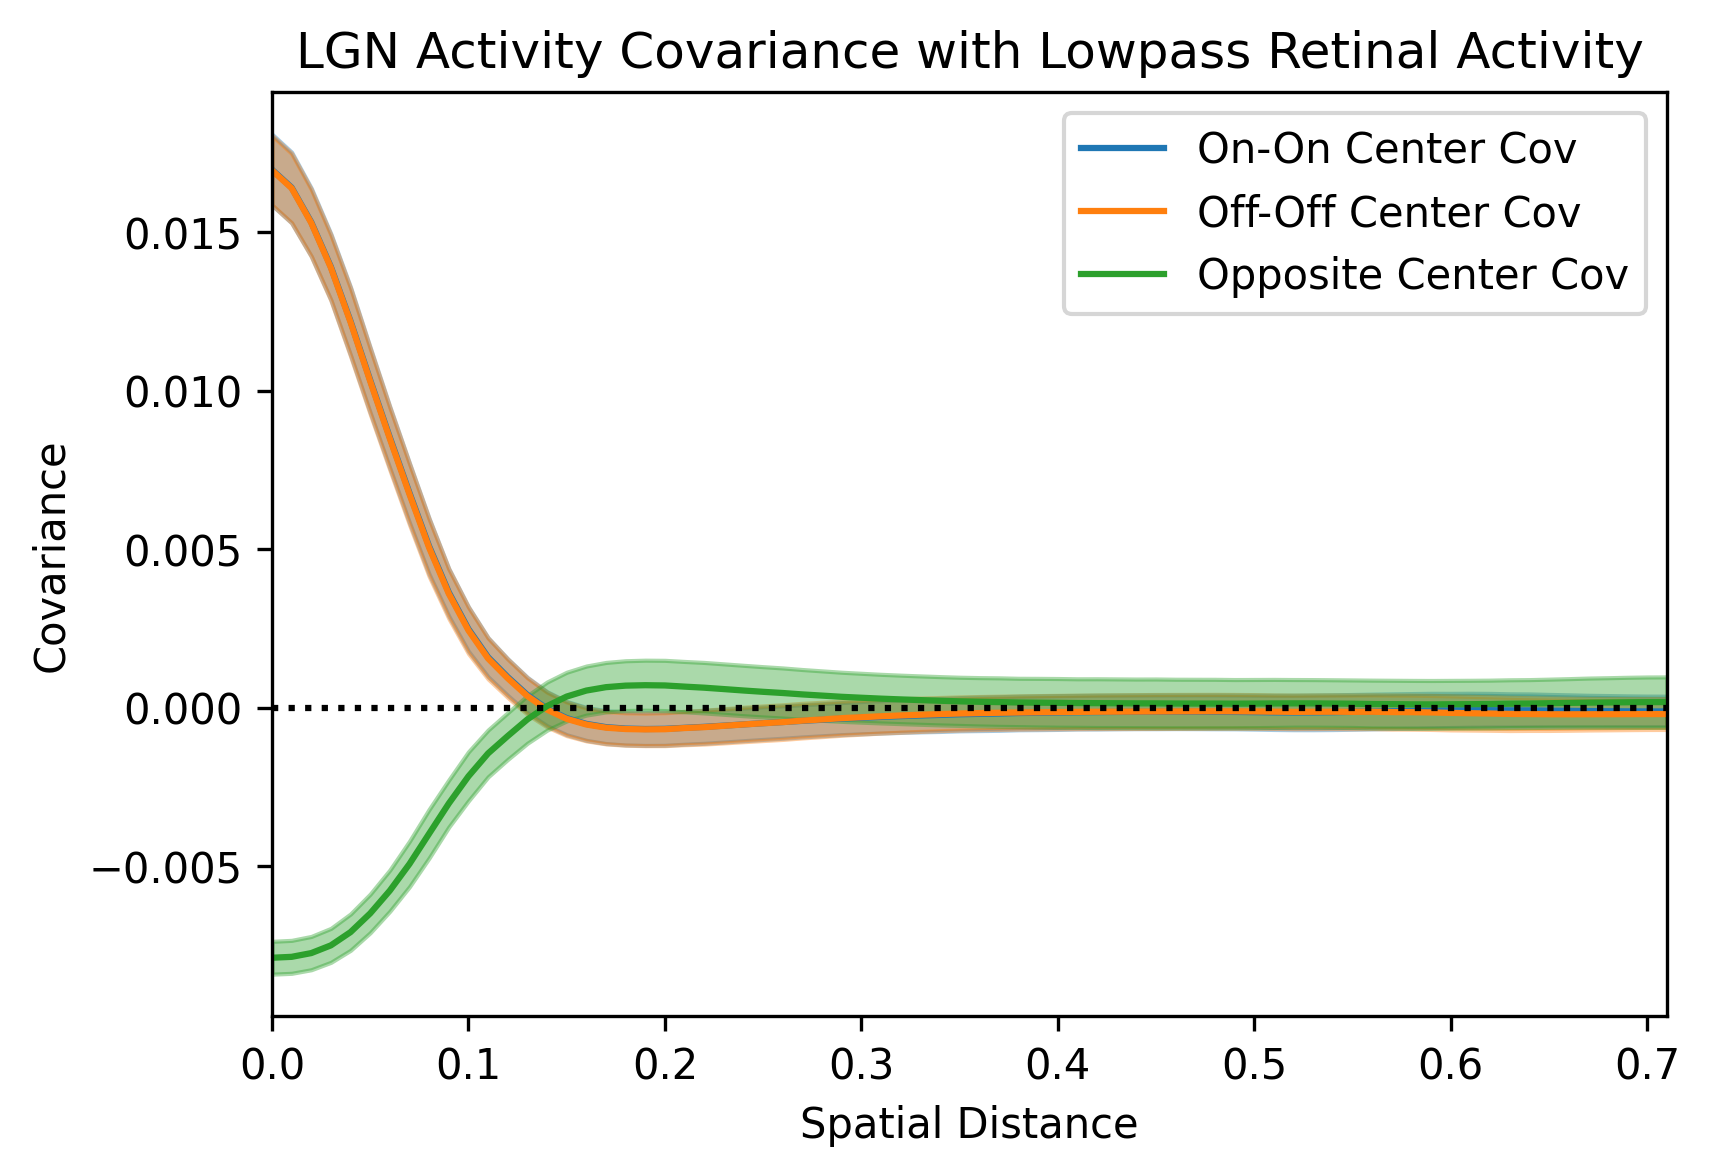

In [32]:
fig,axs = plt.subplots(1,1,figsize=(6,4),dpi=300,sharex=True,sharey=True)
fig.subplots_adjust(hspace=.2, wspace=.2)

axs.plot(dists,low_SN_cov,c='C0',label='On-On Center Cov')
axs.fill_between(dists,low_SN_cov-low_SN_cov_err,low_SN_cov+low_SN_cov_err,color='C0',alpha=0.4)
axs.plot(dists,low_SF_cov,c='C1',label='Off-Off Center Cov')
axs.fill_between(dists,low_SF_cov-low_SF_cov_err,low_SF_cov+low_SF_cov_err,color='C1',alpha=0.4)
axs.plot(dists,low_D_cov,c='C2',label='Opposite Center Cov')
axs.fill_between(dists,low_D_cov-low_D_cov_err,low_D_cov+low_D_cov_err,color='C2',alpha=0.4)

# for i in range(2):
#     axs[i].plot(dists,5*WRtoT_d,'k--',label='Receptive Field')
axs.axhline(0,c='k',ls=':')

axs.legend()

axs.set_xlim(dists[0],dists[-1])

axs.set_xlabel('Spatial Distance')
axs.set_ylabel('Covariance')
    
axs.set_title('LGN Activity Covariance with Lowpass Retinal Activity')

# Look at Correlations with Retinal Waves

In [44]:
def ret_wave(x,y,radius=0.25,width=0.02,grid_size=1.0,n_grid=Nret):
    pts = np.arange(n_grid)*grid_size/n_grid - grid_size/2
    
    dx,dy = np.meshgrid(pts,pts)
    
    return np.roll(np.exp(-0.5*(np.sqrt(dx**2+dy**2)-radius)**2/width**2),(x-n_grid//2,y-n_grid//2),(0,1))

Text(0.5, 1.0, 'Off Layer Activation')

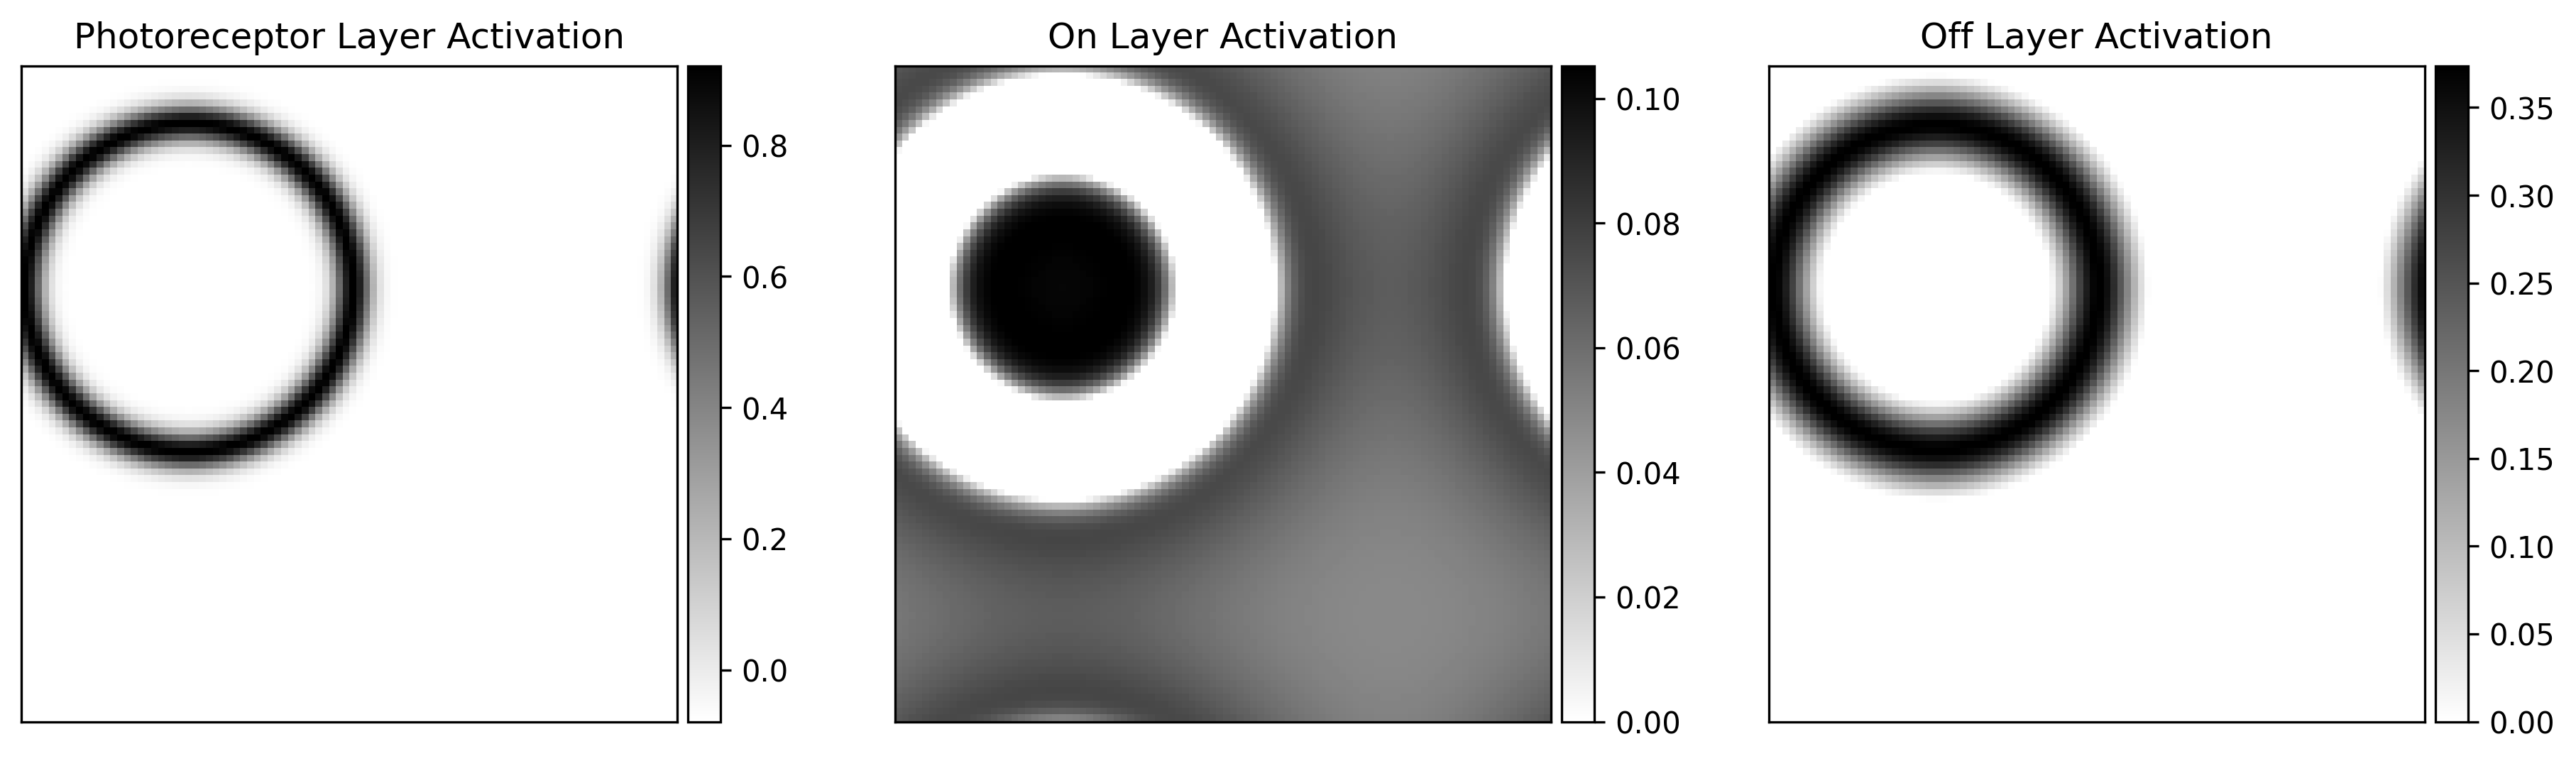

In [45]:
fig,axs = plt.subplots(1,3,figsize=(15,4),dpi=300)

psi = ret_wave(Nret//3,Nret//4)
psi -= np.mean(psi)
Wpatt = np.matmul(WRtoT,psi.flatten()).reshape(Nret,Nret)
pf.imshowbar(fig,axs[0],psi,cmap='binary')
pf.imshowbar(fig,axs[1],fio_rect(-Wpatt),cmap='binary')
pf.imshowbar(fig,axs[2],fio_rect(Wpatt),cmap='binary')

axs[0].set_title('Photoreceptor Layer Activation')
axs[1].set_title('On Layer Activation')
axs[2].set_title('Off Layer Activation')

In [95]:
def ret_onof_wave(x,y,seed=0,init_radius=0.25,grid_size=1.0,n_grid=Nret):
    rng = np.random.default_rng(seed)
    gridx = np.linspace(-0.5,0.5,N,endpoint=False)
    gridy = np.linspace(-0.5,0.5,N,endpoint=False)
    dx,dy = np.meshgrid(gridx,gridy)
    dist_on = np.sqrt(dx**2 + dy**2)

    init_r = np.clip(rng.normal(size=1) * init_radius*0.9 + init_radius,0.01,0.5)
    # vel = np.clip(rng.normal(size=1) * 0.02 + 0.1,0.01,0.15)
    width = rng.uniform(0.05,0.15,1)

    of_x = int(np.round(x + rng.uniform(-0.3,0.3,1)*n_grid))
    of_y = int(np.round(y + rng.uniform(-0.3,0.3,1)*n_grid))
    gridx = np.linspace(-0.5,0.5,N,endpoint=False)
    gridy = np.linspace(-0.5,0.5,N,endpoint=False)
    width_of = rng.uniform(0.05,0.15,1)
    dx,dy = np.meshgrid(gridx,gridy)
    dist_of = np.sqrt(dx**2 + dy**2)
    
    circle_on = np.logical_and( dist_on > (init_r),\
                dist_on < (init_r + width) ).astype(float)# * dist_on

    circle_of = np.logical_and( dist_of > (init_r),\
                dist_of < (init_r + width_of) ).astype(float)# * dist_of
    
    return np.roll(circle_on,(x-n_grid//2,y-n_grid//2),(0,1)),\
        np.roll(circle_of,(of_x-n_grid//2,of_y-n_grid//2),(0,1))

Text(0.5, 1.0, 'Off Layer Activation')

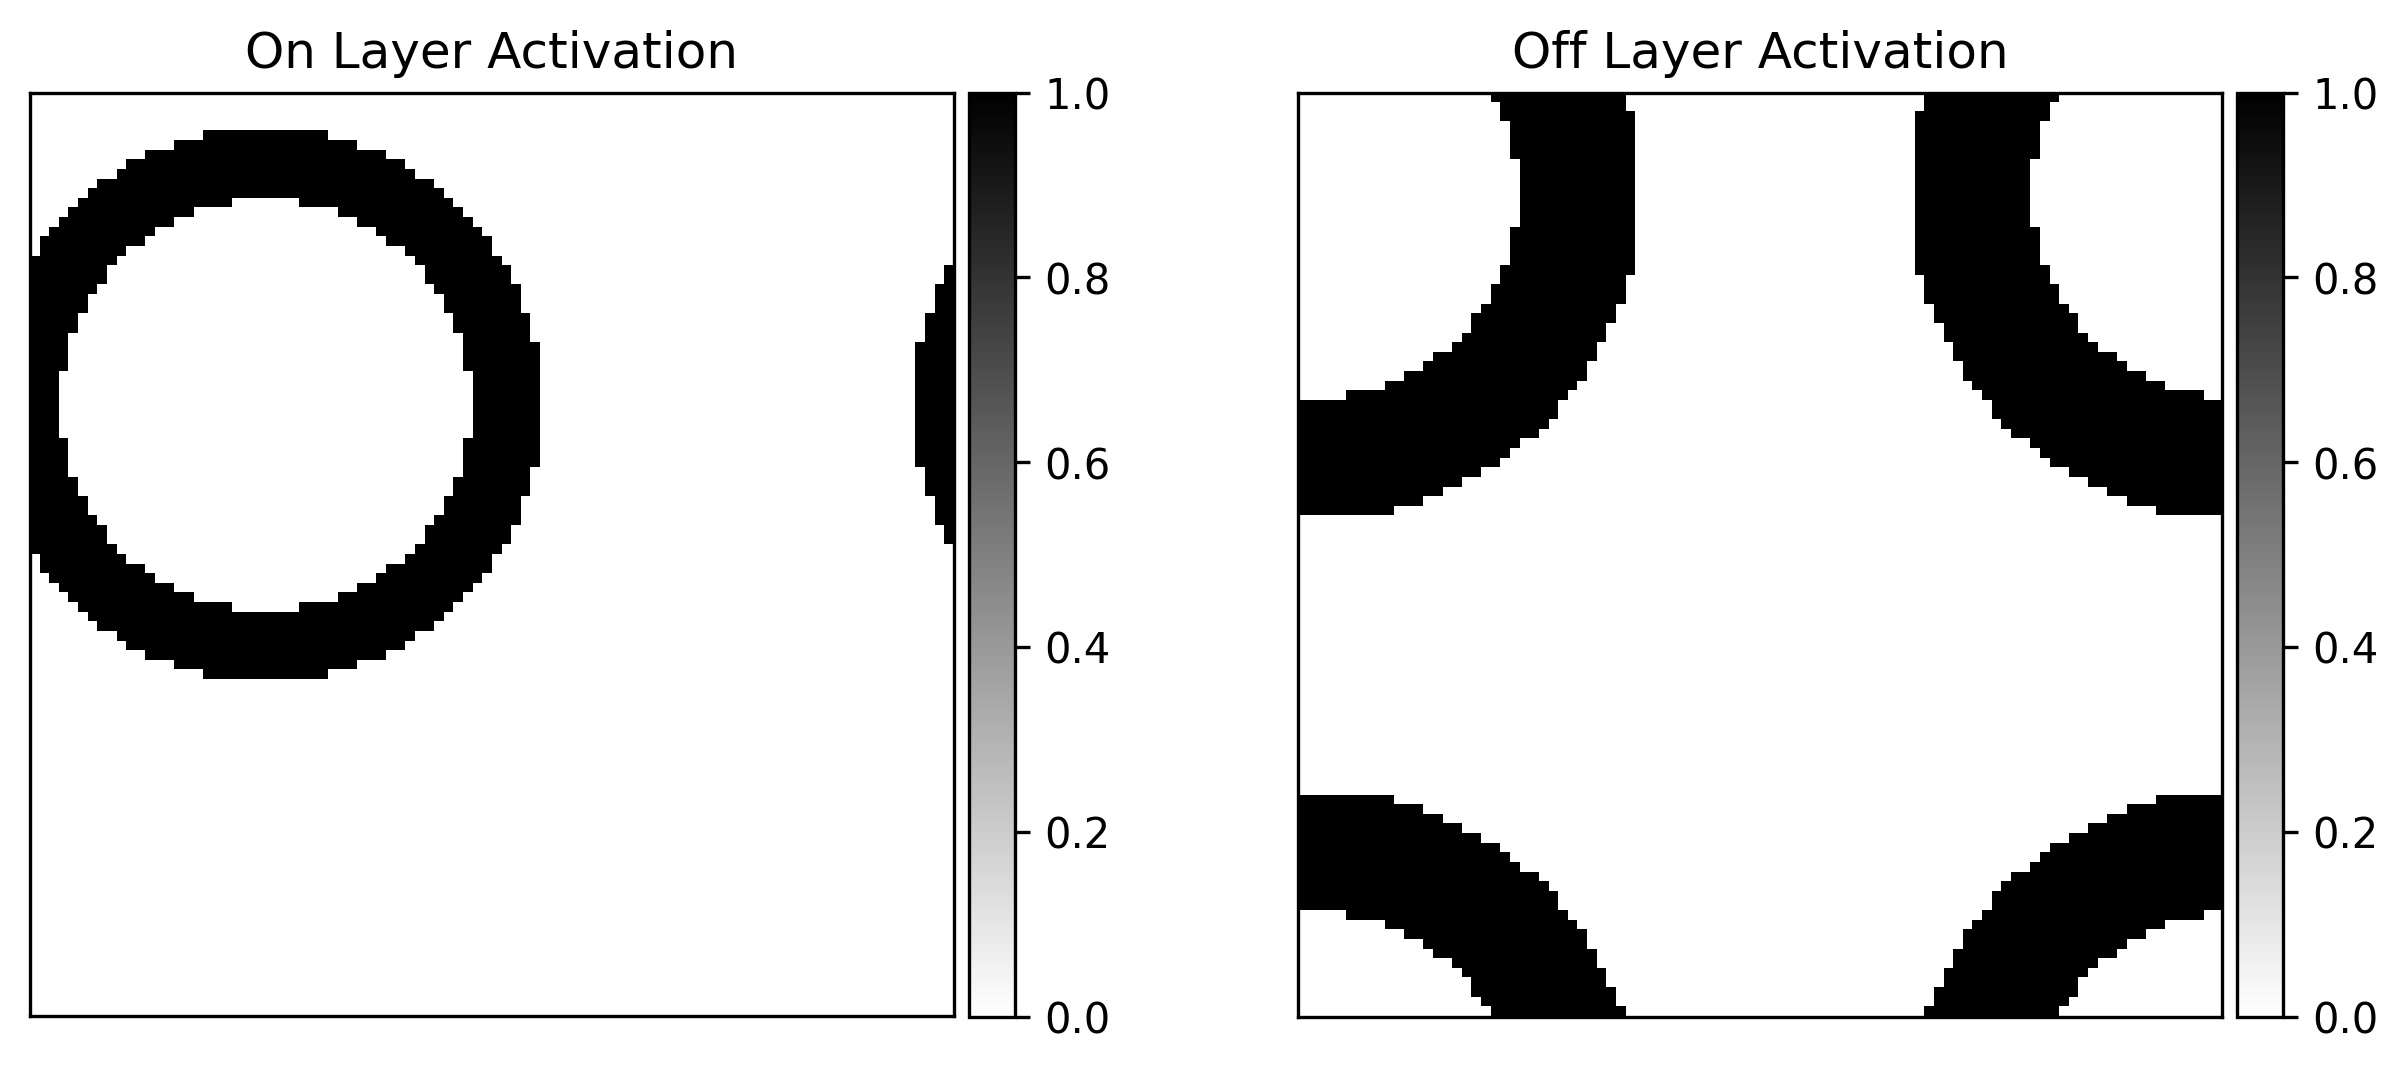

In [86]:
fig,axs = plt.subplots(1,2,figsize=(10,4),dpi=300)

on,of = ret_onof_wave(Nret//3,Nret//4,0,0.2)
pf.imshowbar(fig,axs[0],on,cmap='binary')
pf.imshowbar(fig,axs[1],of,cmap='binary')

axs[0].set_title('On Layer Activation')
axs[1].set_title('Off Layer Activation')

In [96]:
n_ret_patts = 1000
ring_psis = np.zeros((2,n_ret_patts,Nret,Nret))
for i in range(n_ret_patts):
    ring_psis[0,i,:],ring_psis[1,i,:] = ret_onof_wave(np.random.default_rng(0).integers(Nret,size=(n_ret_patts))[i],
                                    np.random.default_rng(1).integers(Nret,size=(n_ret_patts))[i],i,
                                    0.05+0.2*np.random.default_rng(2).random(size=(n_ret_patts))[i])
ring_psis = ring_psis.reshape((2,n_ret_patts,Nret**2))
# ring_psis = 0.25*np.stack([ret_onof_wave(np.random.default_rng(0).integers(Nret,size=(n_ret_patts))[i],
#                                     np.random.default_rng(1).integers(Nret,size=(n_ret_patts))[i],i,
#                                     0.05+0.2*np.random.default_rng(2).random(size=(n_ret_patts))[i]) for i in
#                       range(n_ret_patts)]).reshape(
#     2,n_ret_patts,Nret**2)

In [97]:
ring_N_act = ring_psis[0]
ring_F_act = ring_psis[1]

In [98]:
ring_full_cov = np.cov(ring_N_act.T,ring_F_act.T)
ring_NN_cov = ring_full_cov[:N**2,:N**2]
ring_NF_cov = ring_full_cov[:N**2,N**2:]
ring_FN_cov = ring_full_cov[N**2:,:N**2]
ring_FF_cov = ring_full_cov[N**2:,N**2:]

In [99]:
dists = np.linspace(0,0.71,72)
bin_idxs_4d = np.digitize(ds,np.linspace(0,0.7,71)+0.005)
bin_idxs_2d = np.digitize(ds[0,:],np.linspace(0,0.7,71)+0.005)

ring_SN_cov = np.zeros(72)
ring_SN_cov_err = np.zeros(72)
ring_SF_cov = np.zeros(72)
ring_SF_cov_err = np.zeros(72)
ring_D_cov = np.zeros(72)
ring_D_cov_err = np.zeros(72)

for idx in range(72):
    ring_SN_cov[idx] = np.mean(ring_NN_cov[bin_idxs_4d == idx])
    ring_SN_cov_err[idx] = np.sqrt(np.var(ring_NN_cov[bin_idxs_4d == idx]))
    ring_SF_cov[idx] = np.mean(ring_FF_cov[bin_idxs_4d == idx])
    ring_SF_cov_err[idx] = np.sqrt(np.var(ring_FF_cov[bin_idxs_4d == idx]))
    ring_D_cov[idx] = 0.5*(np.mean(ring_NF_cov[bin_idxs_4d == idx]) +\
                           np.mean(ring_NF_cov[bin_idxs_4d == idx]))
    ring_D_cov_err[idx] = np.sqrt(np.var(ring_NF_cov[bin_idxs_4d == idx]) +\
                                  np.var(ring_NF_cov[bin_idxs_4d == idx]))

Text(0.5, 1.0, 'LGN Activity Covariance with Retinal Wave Activity')

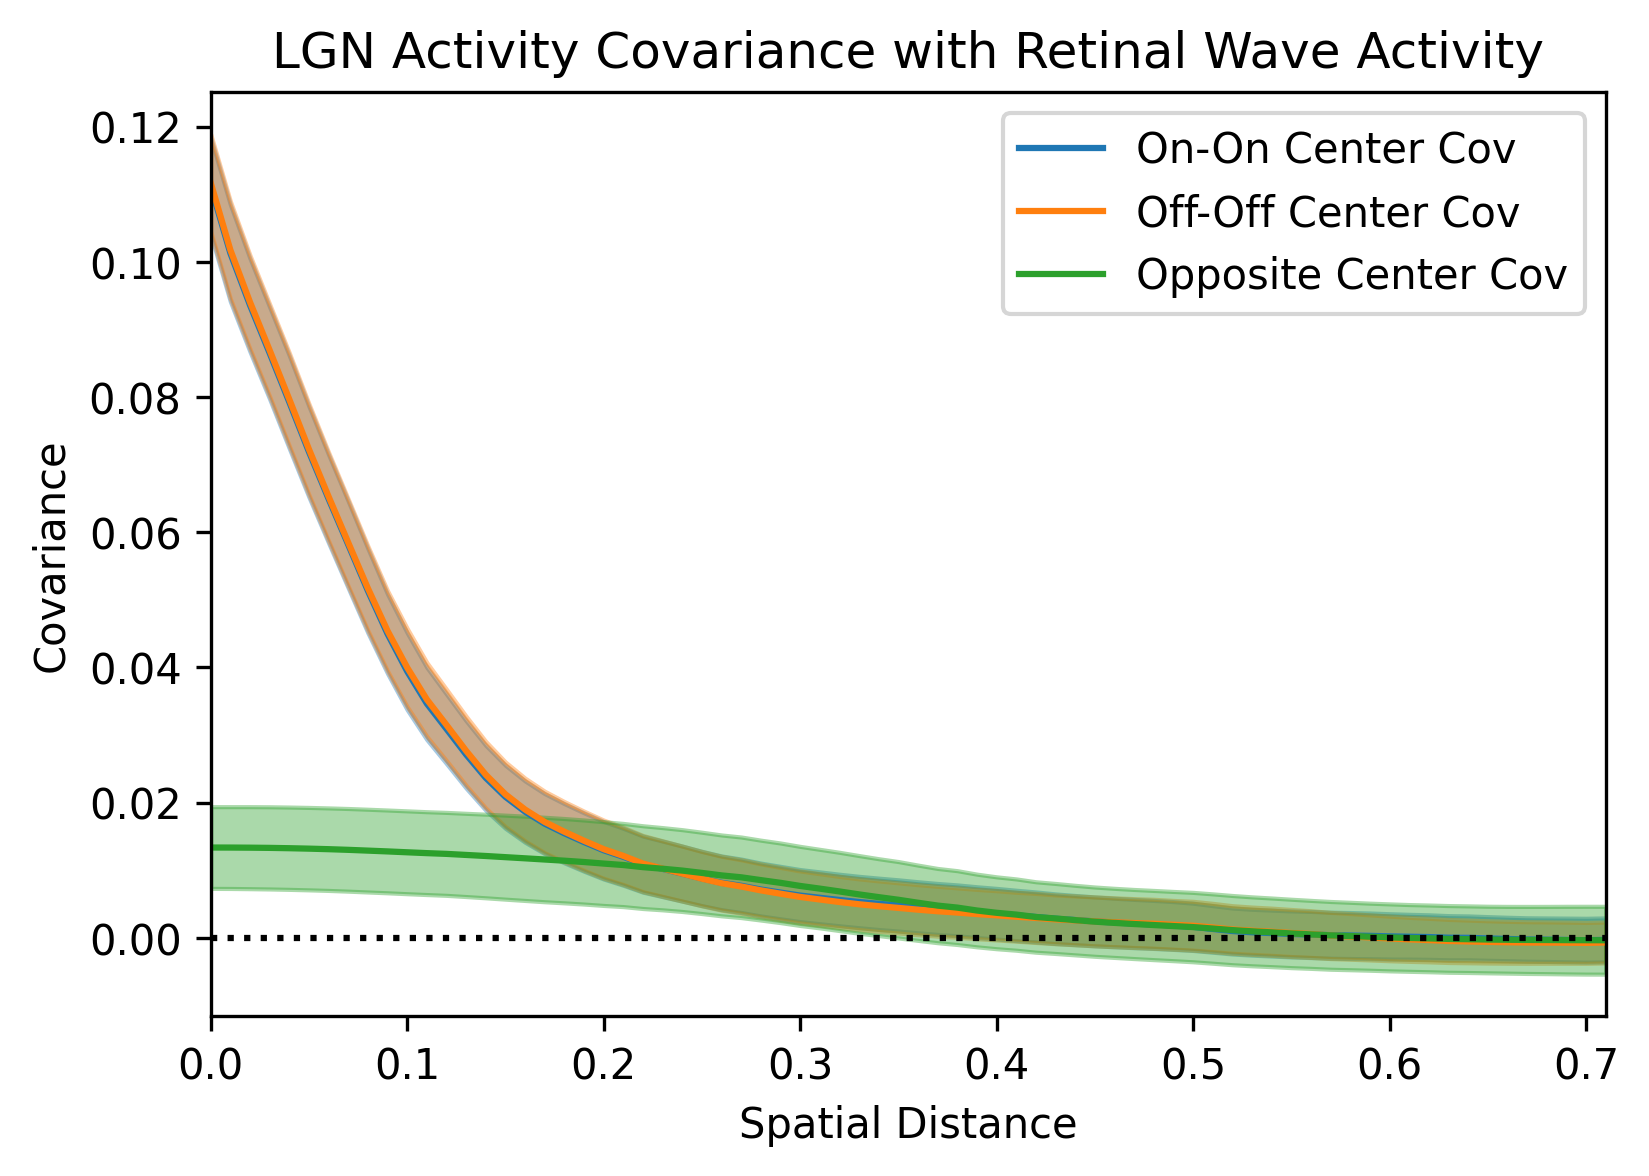

In [100]:
fig,axs = plt.subplots(1,1,figsize=(6,4),dpi=300,sharex=True,sharey=True)
fig.subplots_adjust(hspace=.2, wspace=.2)

axs.plot(dists,ring_SN_cov,c='C0',label='On-On Center Cov')
axs.fill_between(dists,ring_SN_cov-ring_SN_cov_err,ring_SN_cov+ring_SN_cov_err,color='C0',alpha=0.4)
axs.plot(dists,ring_SF_cov,c='C1',label='Off-Off Center Cov')
axs.fill_between(dists,ring_SF_cov-ring_SF_cov_err,ring_SF_cov+ring_SF_cov_err,color='C1',alpha=0.4)
axs.plot(dists,ring_D_cov,c='C2',label='Opposite Center Cov')
axs.fill_between(dists,ring_D_cov-ring_D_cov_err,ring_D_cov+ring_D_cov_err,color='C2',alpha=0.4)

# for i in range(2):
#     axs[i].plot(dists,5*WRtoT_d,'k--',label='Receptive Field')
axs.axhline(0,c='k',ls=':')

axs.legend()

axs.set_xlim(dists[0],dists[-1])

axs.set_xlabel('Spatial Distance')
axs.set_ylabel('Covariance')
    
axs.set_title('LGN Activity Covariance with Retinal Wave Activity')

In [ ]:
n_ret_patts = 1000
ring_psis = np.zeros((2,n_ret_patts,Nret,Nret))
for i in range(n_ret_patts):
    ring_psis[0,i,:],ring_psis[1,i,:] = ret_onof_wave(np.random.default_rng(0).integers(Nret,size=(n_ret_patts))[i],
                                    np.random.default_rng(1).integers(Nret,size=(n_ret_patts))[i],i,
                                    0.05+0.2*np.random.default_rng(2).random(size=(n_ret_patts))[i])
ring_psis = ring_psis.reshape((2,n_ret_patts,Nret**2))
# ring_psis = 0.25*np.stack([ret_onof_wave(np.random.default_rng(0).integers(Nret,size=(n_ret_patts))[i],
#                                     np.random.default_rng(1).integers(Nret,size=(n_ret_patts))[i],i,
#                                     0.05+0.2*np.random.default_rng(2).random(size=(n_ret_patts))[i]) for i in
#                       range(n_ret_patts)]).reshape(
#     2,n_ret_patts,Nret**2)